In [3]:
!pip install networkx pingouin dowhy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.9/198.9 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.5/174.5 kB 13.1 MB/s eta 0:00:00


In [1]:
import pandas as pd
import numpy as np
import pickle
import networkx as nx
import pingouin as pg
from dowhy import CausalModel
import matplotlib.pyplot as plt
import graphviz
import pylab

np.random.seed(0)

# Загрузка данных и вспомогательные функции

In [2]:
df = pd.read_csv('ci_data_internship.csv')

In [3]:
df.head()

Unnamed: 0          id                                 address  is_holiday  \
0           0  10111423.0  7435 East Tulare Avenue, Fresno, 93737         0.0   
1           1  10111423.0  7435 East Tulare Avenue, Fresno, 93737         0.0   
2           2  10111423.0  7435 East Tulare Avenue, Fresno, 93737         0.0   
3           3  10111423.0  7435 East Tulare Avenue, Fresno, 93737         0.0   
4           4  10111423.0  7435 East Tulare Avenue, Fresno, 93737         0.0   

   day_type  season  comp_activity  M_promo_exp  M_promo_internet  \
0       1.0     3.0            0.0          NaN               0.0   
1       1.0     3.0            0.0          0.0               0.0   
2       0.0     3.0            0.0          0.0               0.0   
3       0.0     3.0            0.0          0.0               0.0   
4       0.0     3.0            0.0          0.0               0.0   

   M_promo_banners  S_price  M_price  menu_type  average_purchase_items  \
0              0.0    279.0      NaN        1.0                1.397272   
1              0.0    279.0      0.0        1.0                1.406686   
2              0.0    279.0      0.0        1.0                1.387417   
3              0.0    279.0      0.0        1.0                1.503351   
4              0.0    279.0      0.0        1.0                1.542436   

   average_paycheck  repeated_customers_number  customers_number  M_sales  \
0       1149.887204                        3.0             278.0      0.0   
1        990.536338                        4.0             297.0      0.0   
2       1030.467712                        7.0             289.0      0.0   
3       1069.963783                        8.0             291.0      0.0   
4        931.799035                        8.0             297.0      0.0   

      S_sales  
0  325.649802  
1  363.303956  
2  381.740162  
3  362.562682  
4  369.368186

In [4]:
df = df.drop(['Unnamed: 0', 'id'], axis=1)

In [6]:
df = df.fillna(0)

In [7]:
address_values = list(df.address)
address_values = list(map(str, address_values))
address_number_values = list(map(lambda address: int(address.split()[0]), address_values))

In [8]:
df['address'] = address_number_values

In [10]:
def nudge(pos, x_shift, y_shift):
    return {n:(x + x_shift, y + y_shift) for n,(x,y) in pos.items()}

# визуализация
def draw_graph(G, pos, special_nodes=[]):
    colors = ['red' if (y,x) in G.edges() else 'black' for (x,y) in G.edges()]
    nodes_colors = ['red' if node in special_nodes else 'w' for node in G.nodes()]

    pos_nodes = nudge(pos, 0.0, -0.5)

    fig, ax = plt.subplots(1, figsize=(16, 16))
    ax.margins(0.2)
    nx.draw(G, ax=ax, pos=pos, with_labels=False, node_size=500, node_color=nodes_colors, edgecolors='black', edge_color=colors)
    nx.draw_networkx_labels(G, ax=ax, pos=pos_nodes, font_size=12)

In [11]:
pos = {'address':(4, 5), 'is_holiday':(6.5, 5.5), 'day_type':(5.7, 7), 'season':(2.5, 4.7), 'comp_activity':(1.8,2.8),
       'M_promo_exp':(7, 4.5), 'M_promo_internet':(0.5,0.5), 'M_promo_banners':(3, 0.5), 'S_price':(7.6,0.), 'M_price':(5.3, 0.7), 'menu_type':(4.4,1.9),
       'average_purchase_items': (4.2, 3.5), 'average_paycheck': (4.8, 5.2), 'repeated_customers_number': (3.2, 5.8), 'customers_number': (6.0, 3.0),
       'M_sales': (7.3, 2.5), 'S_sales': (7.9, 1.2)}

# Алгоритм Петера-Кларка

In [12]:
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.PCUtils.BackgroundKnowledge import BackgroundKnowledge

Значение $\alpha$ пришлось увеличить до 0.2, т.к. при $\alpha = 0.05$ и $\alpha = 0.1$ причинно-следственный граф получался циклическим.

In [13]:
alpha = 0.2

In [14]:
graph_pc_raw = pc(df.values, alpha=alpha, indep_test='fisherz')

  0%|          | 0/17 [00:00<?, ?it/s]

In [15]:
graph_pc_raw.to_nx_graph()

mapping = {node:i for node, i in enumerate(df.columns)}
mapping_r = {i:node for node, i in enumerate(df.columns)}

graph_pc = nx.relabel_nodes(graph_pc_raw.nx_graph, mapping)

In [16]:
def get_non_directed_edges(graph):
    edges = list(graph.edges())
    non_directed_edges = []
    for u, v in edges:
        if (v, u) in edges:
            non_directed_edges.append((u, v))
    return non_directed_edges

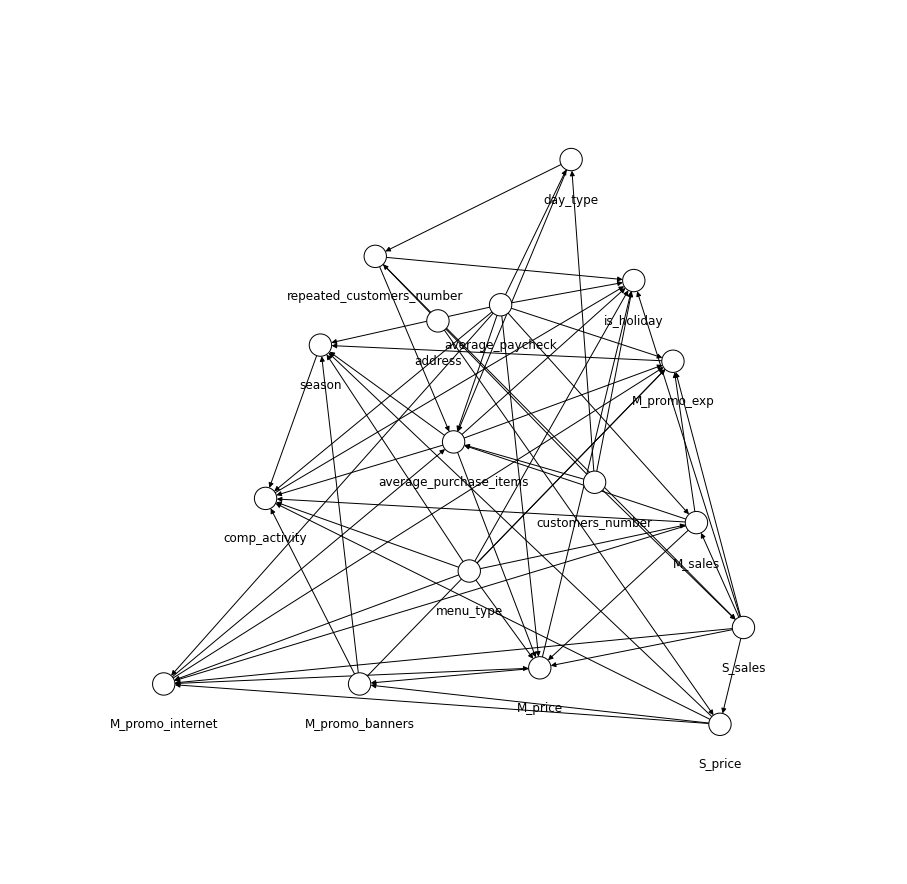

In [17]:
draw_graph(graph_pc, pos)

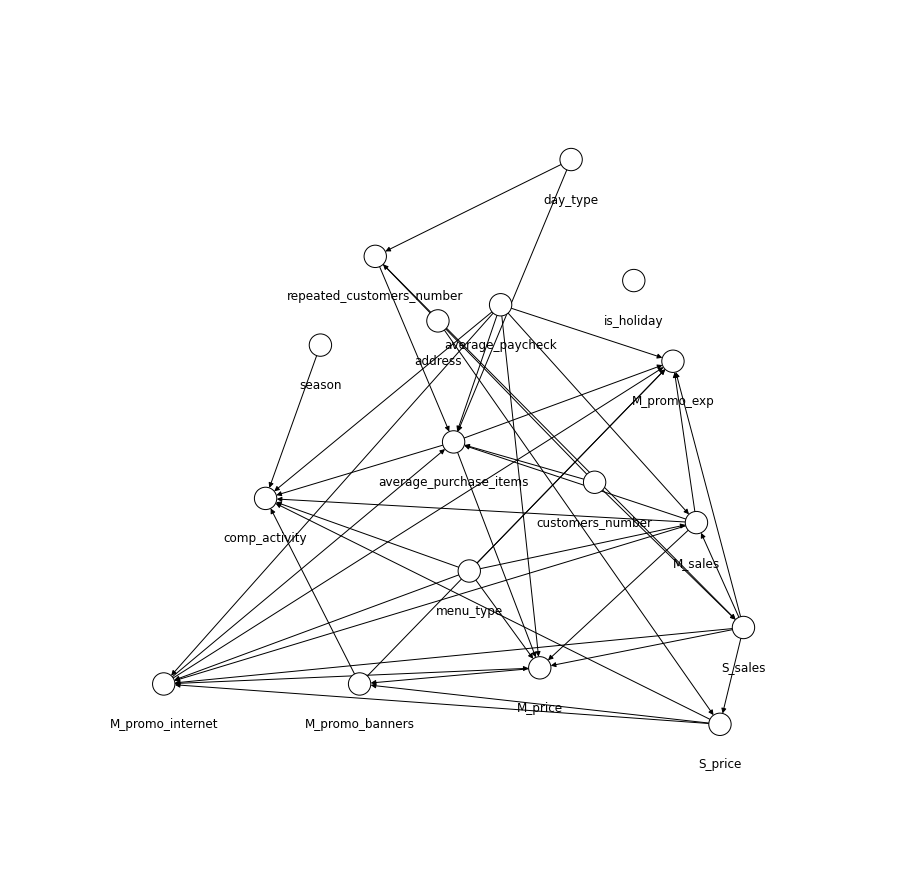

In [18]:
edges_to_remove = [(u, v) for u, v in graph_pc.edges() if v == 'is_holiday']
edges_to_remove += [(u, v) for u, v in graph_pc.edges() if v == 'day_type']
edges_to_remove += [(u, v) for u, v in graph_pc.edges() if v == 'season']
edges_to_remove += [(u, v) for u, v in graph_pc.edges() if v == 'address']
edges_to_remove += [(u, v) for u, v in graph_pc.edges if (u, v) in get_non_directed_edges(graph_pc)]
graph_pc.remove_edges_from(edges_to_remove)
draw_graph(graph_pc, pos)

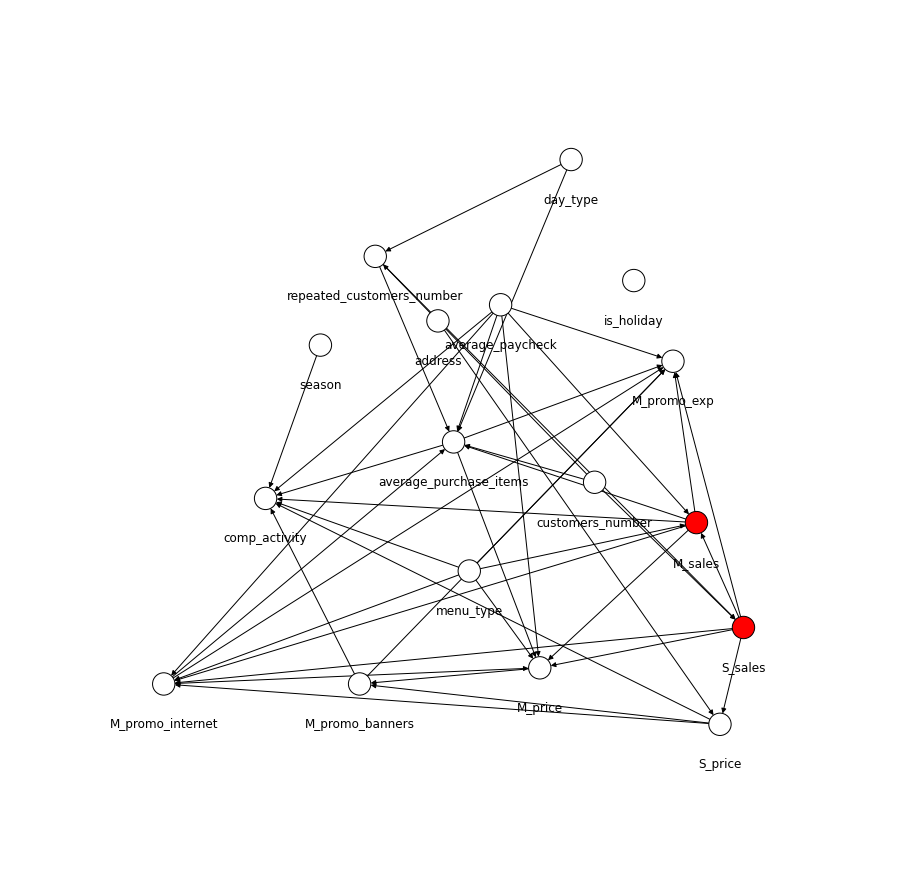

In [19]:
draw_graph(graph_pc, pos, ['M_sales', 'S_sales'])

In [22]:
pc_edges = pd.DataFrame(columns=['from', 'to'])

for edge in list(graph_pc.edges()):
    pc_edges.loc[len(pc_edges)] = edge
    
pc_edges.to_csv('pc_edges.csv')

In [24]:
pc_edges.shape

# Вычисление влияния S_sales на M_sales

In [59]:
gml = ''.join(nx.generate_gml(graph_pc))
model = CausalModel(
        data=df,
        treatment='S_sales',
        outcome='M_sales',
        graph=gml)

In [60]:
identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d               
─────────(E[Mₛₐₗₑₛ])
d[Sₛₐₗₑₛ]           
Estimand assumption 1, Unconfoundedness: If U→{S_sales} and U→M_sales then P(M_sales|S_sales,,U) = P(M_sales|S_sales,)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                                                                                 ↪
 ⎢                      d                                ⎛                      d                  ↪
E⎢──────────────────────────────────────────────(Mₛₐₗₑₛ)⋅⎜──────────────────────────────────────── ↪
 ⎣d[customers_number  repeated_customers_number]         ⎝d[customers_number  repeated_customers_n ↪

↪                  -1⎤
↪                 ⎞  ⎥
↪ ──────([Sₛₐₗₑₛ])⎟  ⎥
↪ umber]          ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→M_sales then ¬(U →→{customers_number,repeated_customers_number})
Estimand assumption 2, Exclusion: If we remove 

In [61]:
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")
print("Оценка эффекта: " + str(estimate.value))

Оценка эффекта: -0.6296581201220306


# Алгоритм SGS

## Нахождение скелета графа

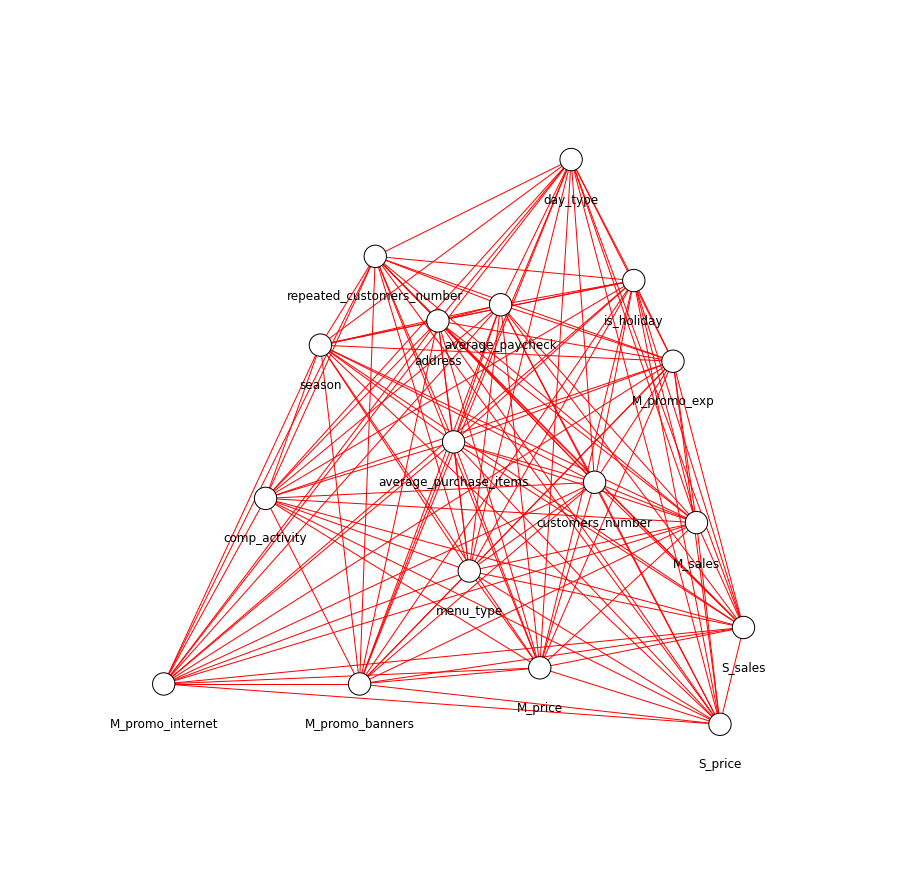

In [ ]:
nodes = list(df.columns)
skeleton = nx.Graph()
skeleton.add_nodes_from(nodes)
skeleton.add_edges_from(combinations(nodes, 2))
draw_graph(skeleton, pos)

In [ ]:
def skeleton_learning(df, skeleton, alpha=0.05, verbose=False):
    time_ = []

    for k in range(len(skeleton.nodes()) - 1):
        start = time.time()
        for x, y in combinations(skeleton.nodes(), 2):
            for s in combinations(set(skeleton.nodes()).difference([x, y]), k):
                p_val = pg.partial_corr(data=df, x=x, y=y, covar=list(s)).round(3)['p-val'].item()
                if p_val > alpha and skeleton.has_edge(x, y):
                    if verbose:
                        print('removing edge: ', (x, y))
                    skeleton.remove_edge(x, y)
        end = time.time()
        time_.append(end - start)

        draw_graph(skeleton, pos)
        plt.text(0.2, 7, f'k = {k}', fontsize=34)
        plt.text(0.2, 6.4, f'time = {round(time_[-1], 2)}', fontsize=24)

    return skeleton, time_

removing edge:  ('address', 'is_holiday')
removing edge:  ('address', 'day_type')
removing edge:  ('address', 'season')
removing edge:  ('address', 'comp_activity')
removing edge:  ('address', 'M_promo_exp')
removing edge:  ('address', 'M_promo_internet')
removing edge:  ('address', 'M_promo_banners')
removing edge:  ('address', 'M_price')
removing edge:  ('address', 'menu_type')
removing edge:  ('address', 'average_purchase_items')
removing edge:  ('address', 'average_paycheck')
removing edge:  ('address', 'customers_number')
removing edge:  ('address', 'M_sales')
removing edge:  ('address', 'S_sales')
removing edge:  ('day_type', 'season')
removing edge:  ('day_type', 'S_price')
removing edge:  ('comp_activity', 'customers_number')
removing edge:  ('address', 'repeated_customers_number')
removing edge:  ('is_holiday', 'day_type')
removing edge:  ('is_holiday', 'S_price')
removing edge:  ('day_type', 'comp_activity')
removing edge:  ('day_type', 'M_promo_exp')
removing edge:  ('day_ty

MemoryError: Unable to allocate 3.09 MiB for an array with shape (6, 540000) and data type bool

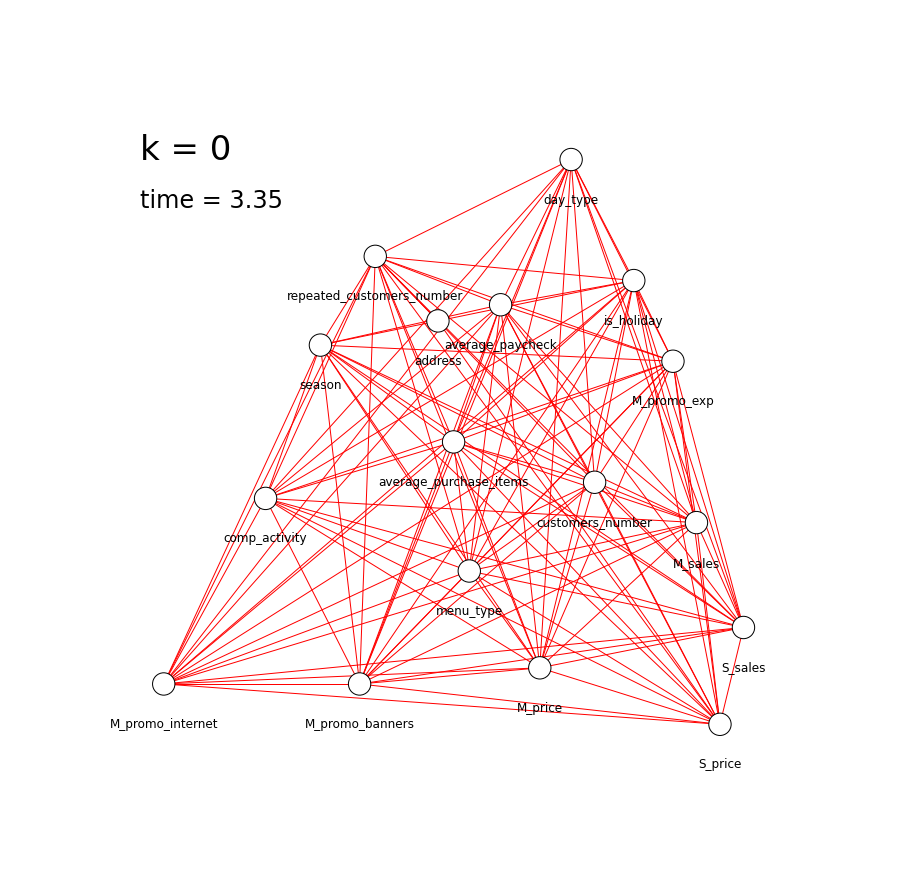

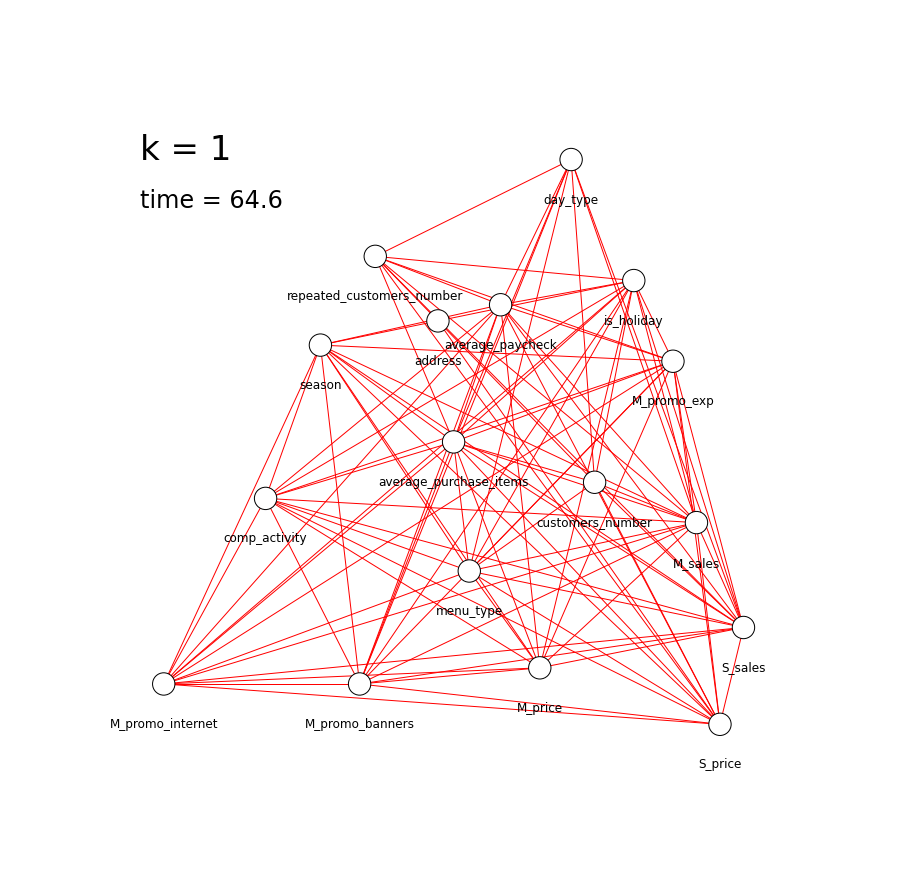

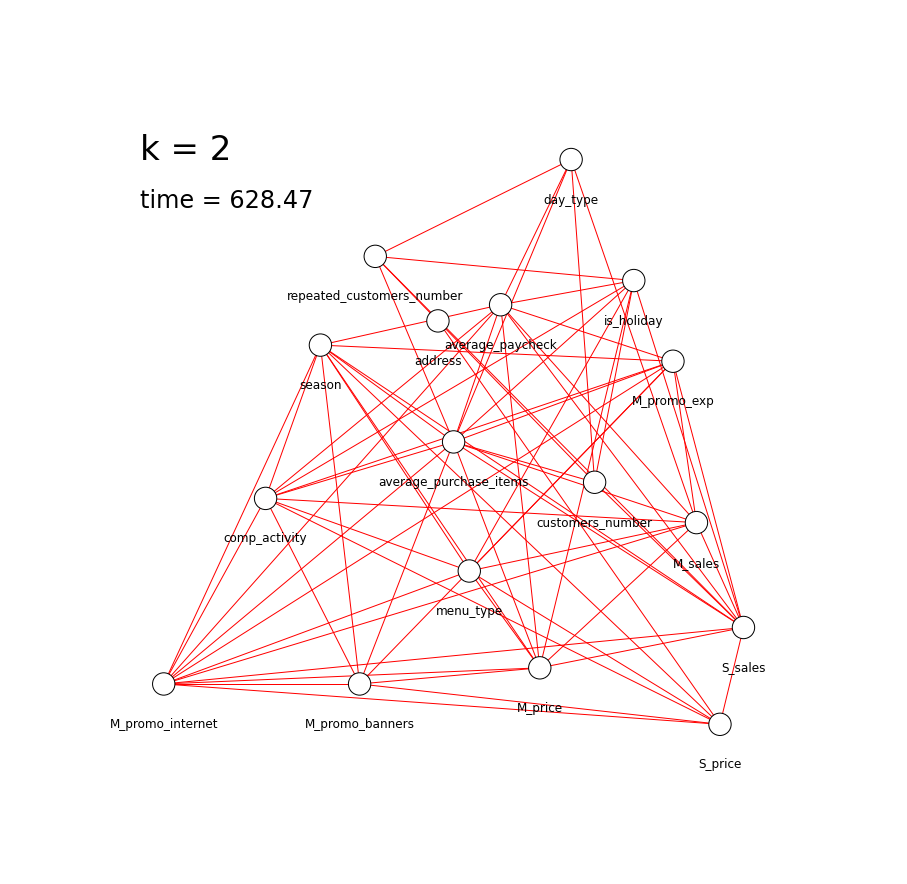

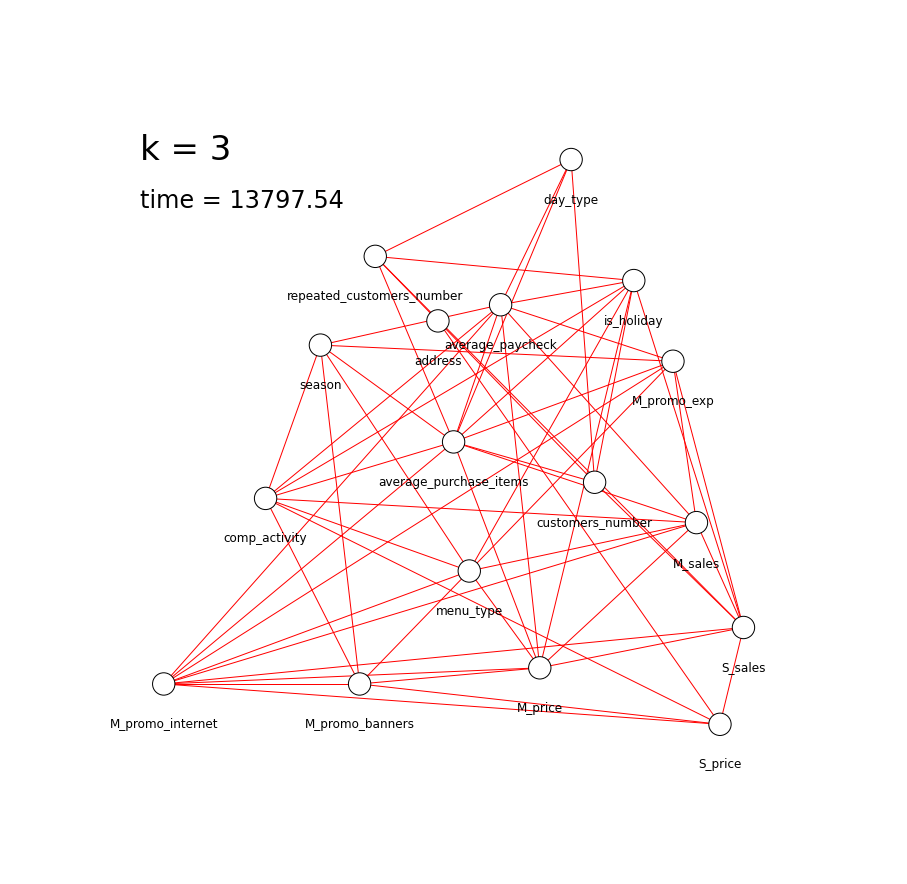

In [ ]:
skeleton, time_ = skeleton_learning(df, skeleton, alpha, verbose=True)
draw_graph(skeleton, pos)

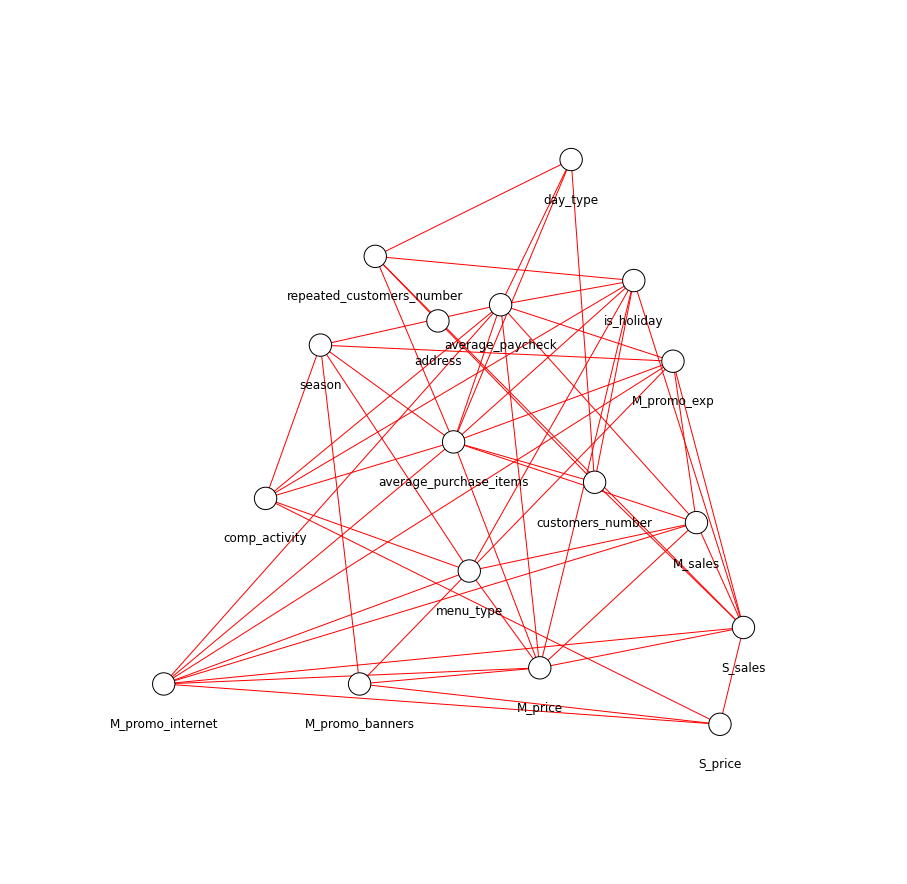

In [ ]:
draw_graph(skeleton, pos)

In [ ]:
nx.write_gml(skeleton, 'skeleton.gml')

In [ ]:
skeleton = nx.read_gml('skeleton.gml')

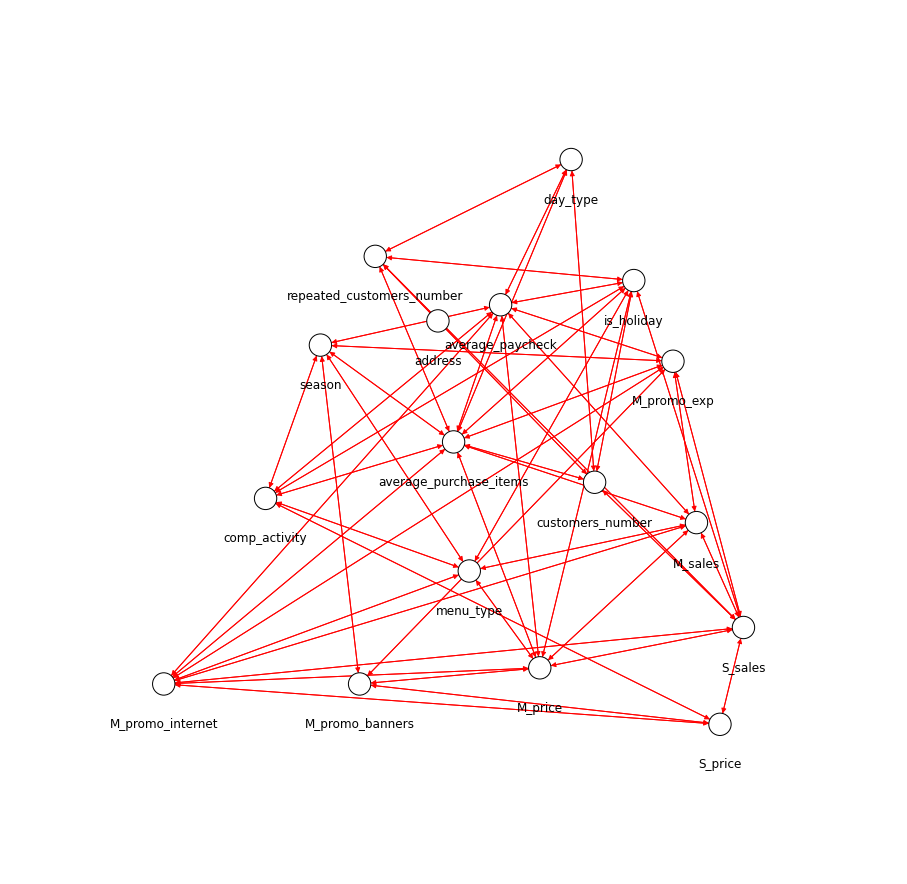

In [ ]:
directed = skeleton.to_directed()
draw_graph(directed, pos)

## Поиск v-структур

In [ ]:
unshielded_triples = []

for i in directed.nodes():
    for j in directed.nodes():
        for k in directed.nodes():
            if i != j and i != k and j != k and (i, j) in directed.edges() and (j, k) in directed.edges() and (i, k) not in directed.edges():
                unshielded_triples.append((i, j, k))

In [ ]:
unshielded_triples = list(set(unshielded_triples))

In [ ]:
v_structures = []
i = 0

for u_triplet in unshielded_triples:
    i += 1
    for k in range(len(skeleton.nodes()) - 2):
        for s in combinations(set(skeleton.nodes()).difference(u_triplet), k):
            s_f = [a for a in s]
            s_f.append(u_triplet[1])
            p_val = pg.partial_corr(data=df, x=u_triplet[0], y=u_triplet[2], covar=list(s_f)).round(3)['p-val'].item()
            if p_val > alpha:
                break
        else:
            continue
        break

    if p_val < alpha:
        v_structures.append(u_triplet)
        directed.remove_edges_from([(u_triplet[1], u_triplet[0]), (u_triplet[1], u_triplet[2])])

    print(f'Iteration {i} / {len(unshielded_triples)}')

#     colors = ['green' if (y, x) in directed.edges() else 'black' for (x, y) in directed.edges()]
#     draw_graph(directed, pos)
#     plt.text(7.76, 8.7, str(i) + '/' + str(len(unshielded_triples)), fontsize=24)
#     plt.text(-1.05, 8, str(u_triplet), fontsize=16)
#     plt.text(-1.05, 7.5, 'Result: ' + str(p_val < alpha), fontsize=14, color='black')

Iteration 1 / 344
Iteration 2 / 344
Iteration 3 / 344
Iteration 4 / 344
Iteration 5 / 344
Iteration 6 / 344
Iteration 7 / 344
Iteration 8 / 344
Iteration 9 / 344
Iteration 10 / 344
Iteration 11 / 344
Iteration 12 / 344


## Применение background knowledge и правил Мика

In [ ]:
edges_to_remove = [(u, v) for u, v in directed.edges() if v == 'is_holiday']
edges_to_remove += [(u, v) for u, v in directed.edges() if v == 'day_type']
edges_to_remove += [(u, v) for u, v in directed.edges() if v == 'season']

directed.remove_edges_from(edges_to_remove)

In [ ]:
draw_graph(directed, pos)

# Алгоритм GES

In [ ]:
from causallearn.search.ScoreBased.GES import ges

graph_ges = ges(df, score_func='local_score_BIC')

In [ ]:
with open('graph_ges.pkl', 'wb') as f:
    pickle.dump(graph_ges, f)

In [ ]:
import io
from causallearn.utils.GraphUtils import GraphUtils
import matplotlib.image as mpimg

pyd = GraphUtils.to_pydot(graph_ges['G'], labels=df.columns)
pyd.write_png('graph_ges.png')

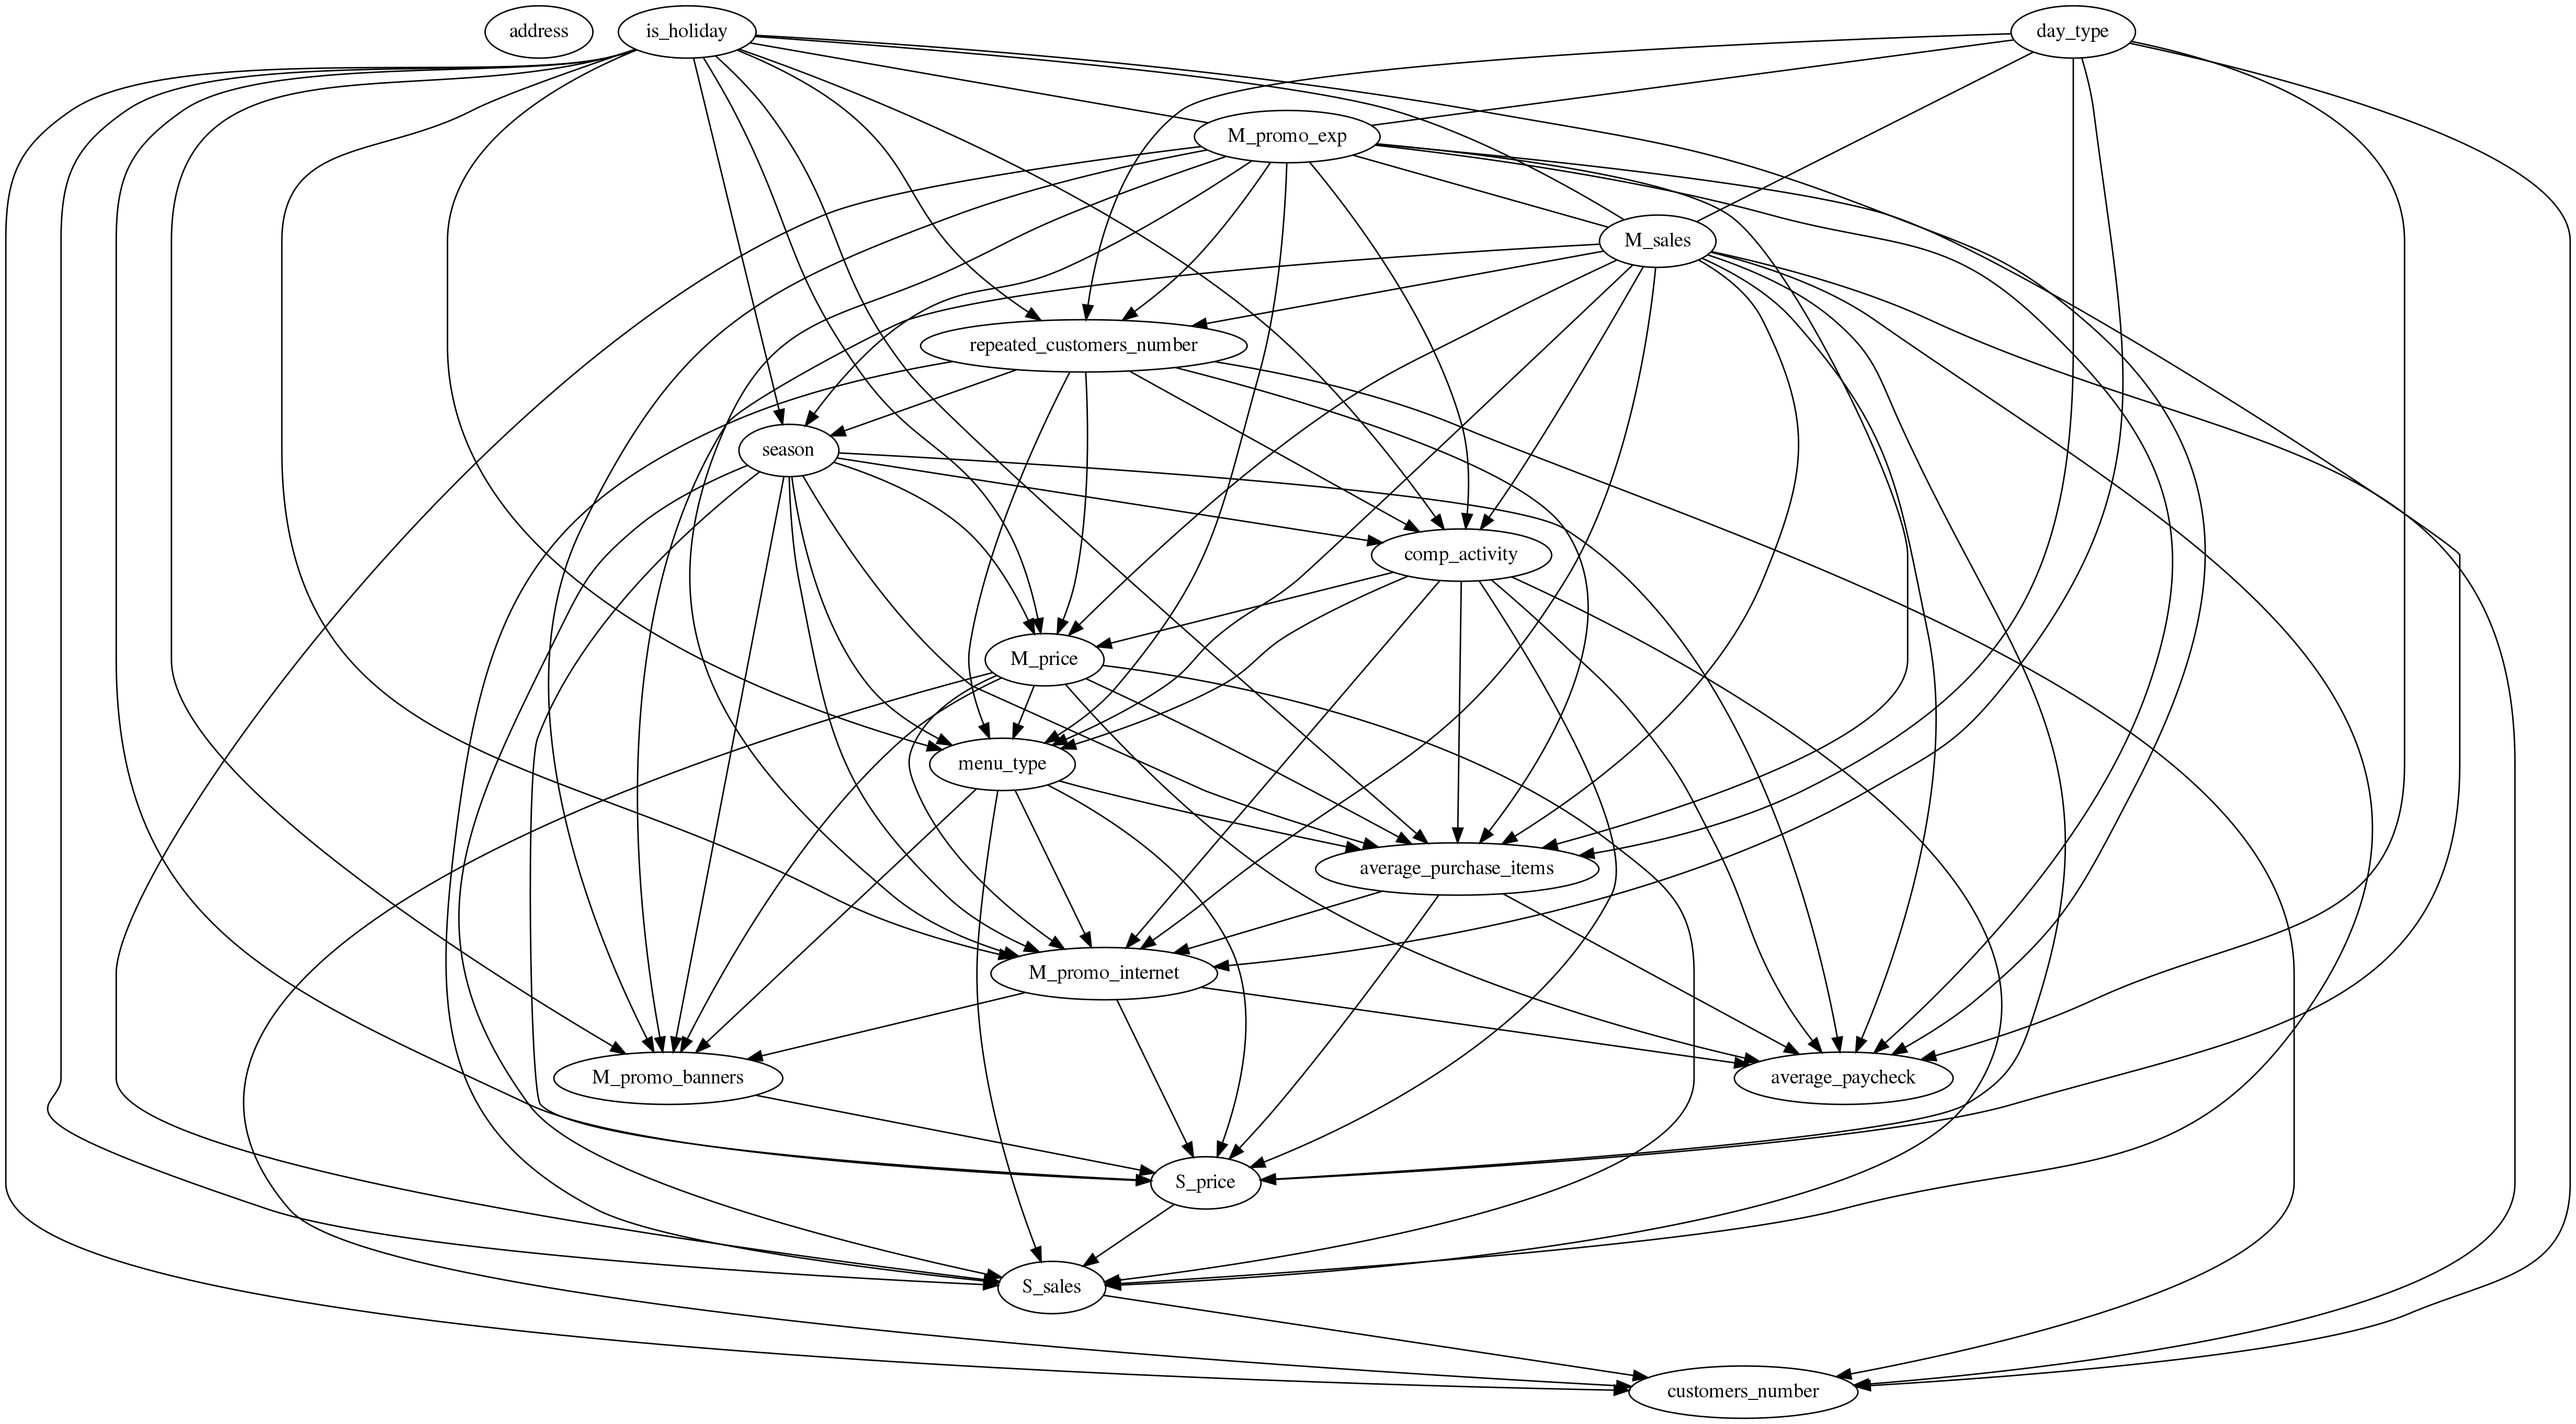

In [ ]:
from IPython.display import Image

Image('graph_ges.png')

Чтобы посчитать эффект связи между S_sales и M_sales, нужно запустить CausalModel. В CausalModel передаётся граф в формате dot

In [ ]:
graph_ges_nodes = graph_ges['G'].get_nodes()
graph_ges_node_names = list(df.columns)

for i in range(len(graph_ges_nodes)):
    for j in range(len(graph_ges_nodes)):
        edge = graph_ges['G'].get_directed_edge(graph_ges_nodes[i], graph_ges_nodes[j])
        if edge is not None:
            print(graph_ges_node_names[i], '->', graph_ges_node_names[j])

is_holiday -> season
is_holiday -> comp_activity
is_holiday -> M_promo_internet
is_holiday -> M_promo_banners
is_holiday -> S_price
is_holiday -> M_price
is_holiday -> menu_type
is_holiday -> average_purchase_items
is_holiday -> average_paycheck
is_holiday -> repeated_customers_number
is_holiday -> customers_number
is_holiday -> S_sales
day_type -> M_promo_internet
day_type -> average_purchase_items
day_type -> average_paycheck
day_type -> repeated_customers_number
day_type -> customers_number
season -> is_holiday
season -> comp_activity
season -> M_promo_exp
season -> M_promo_internet
season -> M_promo_banners
season -> S_price
season -> M_price
season -> menu_type
season -> average_purchase_items
season -> average_paycheck
season -> repeated_customers_number
season -> S_sales
comp_activity -> is_holiday
comp_activity -> season
comp_activity -> M_promo_exp
comp_activity -> M_promo_internet
comp_activity -> S_price
comp_activity -> M_price
comp_activity -> menu_type
comp_activity -> av

Нужно вручную создать dot-file (как это делается, см. Stackoverflow [https://stackoverflow.com/questions/13236975/graphviz-dot-mix-directed-and-undirected]) и добавить туда все вершины и все рёбра из этого списка, отметив, направленные они или нет.

In [65]:
graph = nx.DiGraph(nx.nx_pydot.read_dot('graph_ges_custom.dot'))

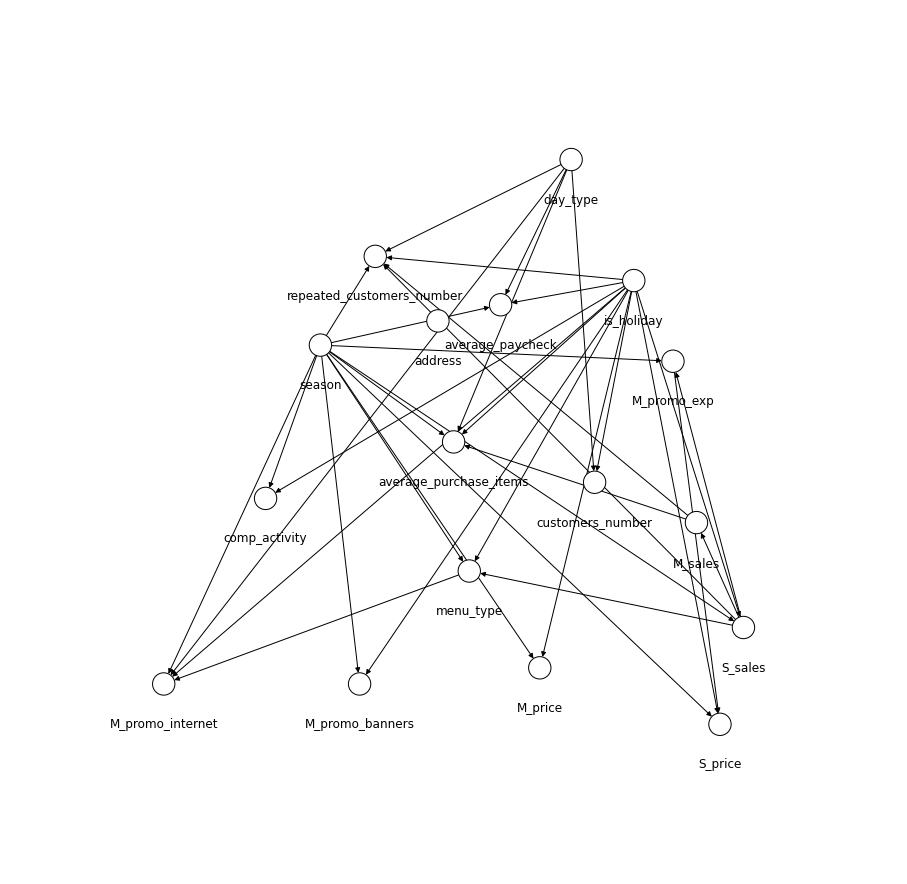

In [69]:
draw_graph(graph, pos)

Применим к полученному графу background knowledge. Нам нужно, чтобы граф был ациклическим

In [68]:
edges_to_remove = [(u, v) for u, v in graph.edges() if v == 'is_holiday']
edges_to_remove += [(u, v) for u, v in graph.edges() if v == 'day_type']
edges_to_remove += [(u, v) for u, v in graph.edges() if v == 'season']
edges_to_remove += [(u, v) for u, v in graph.edges() if v == 'address']
graph.remove_edges_from([('M_sales', 'S_sales')])
edges_to_remove = [(u, v) for u, v in graph.edges if (u, v) in get_non_directed_edges(graph)]

graph.remove_edges_from(edges_to_remove)

In [66]:
graph.remove_edge('M_promo_internet', 'menu_type')
# graph.remove_edge('M_promo_internet', 'S_sales')
graph.remove_edge('menu_type', 'S_sales')
graph.remove_edge('S_price', 'M_promo_exp')
graph.remove_edge('M_promo_exp', 'S_sales')
graph.remove_edge('average_purchase_items', 'M_sales')
graph.remove_edge('repeated_customers_number', 'M_sales')
graph.remove_edge('repeated_customers_number', 'S_sales')
# graph.remove_edge('M_promo_exp', 'M_sales')

In [70]:
graph.add_edge('M_sales', 'M_price')
graph.add_edge('S_sales', 'S_price')

In [ ]:
nodes = list(graph.nodes)

for node1 in nodes:
    for node2 in nodes:
        if graph.has_edge(node1, node2):
            model = CausalModel(
              data=df,
              treatment=node1,
              outcome=node2,
              graph=graph)
            estimate = model.estimate_effect(identified_estimand,
                  method_name="backdoor.linear_regression")
            if abs(estimate.value) < 0.2:
                graph.remove_edge(node1, node2)
                print(node1, node2)

In [ ]:
model = CausalModel(
        data=df,
        treatment='S_sales',
        outcome='M_sales',
        graph=graph)

identified_estimand = model.identify_effect()
print(identified_estimand)

estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")
print("Оценка эффекта: " + str(estimate.value))

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d               
─────────(E[Mₛₐₗₑₛ])
d[Sₛₐₗₑₛ]           
Estimand assumption 1, Unconfoundedness: If U→{S_sales} and U→M_sales then P(M_sales|S_sales,,U) = P(M_sales|S_sales,)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                                               -1⎤
 ⎢          d                   ⎛          d                    ⎞  ⎥
E⎢─────────────────────(Mₛₐₗₑₛ)⋅⎜─────────────────────([Sₛₐₗₑₛ])⎟  ⎥
 ⎣d[is_holiday  season]         ⎝d[is_holiday  season]          ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→M_sales then ¬(U →→{is_holiday,season})
Estimand assumption 2, Exclusion: If we remove {is_holiday,season}→{S_sales}, then ¬({is_holiday,season}→M_sales)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

Оценка эффекта: -0.9311992463210004


In [71]:
ges_edges = pd.DataFrame(columns=['from', 'to'])

for edge in list(graph.edges()):
    ges_edges.loc[len(ges_edges)] = edge
    
ges_edges.to_csv('ges_edges.csv')

In [72]:
ges_edges.shape

# Алгоритм FCI

In [ ]:
from causallearn.search.ConstraintBased.FCI import fci

fci_graph, fci_edges = fci(df.values, alpha=alpha, indep_test='fisherz')

  0%|          | 0/17 [00:00<?, ?it/s]

X10 --> X2
X3 --> X14
X4 --> X5
X6 --> X4
X4 --> X8
X8 --> X6
X6 --> X16
X10 --> X7
X7 --> X11
X7 --> X12
X7 --> X13
X16 --> X10


In [ ]:
graph_fci_nodes = fci_graph.get_nodes()
graph_fci_node_names = list(df.columns)

for i in range(len(graph_fci_nodes)):
    for j in range(len(graph_fci_nodes)):
        edge = fci_graph.get_directed_edge(graph_fci_nodes[i], graph_fci_nodes[j])
        if edge is not None:
            print(graph_fci_node_names[i], '->', graph_fci_node_names[j])

is_holiday -> comp_activity
is_holiday -> M_price
is_holiday -> average_purchase_items
is_holiday -> average_paycheck
is_holiday -> repeated_customers_number
is_holiday -> customers_number
is_holiday -> S_sales
day_type -> average_paycheck
day_type -> repeated_customers_number
day_type -> customers_number
season -> comp_activity
season -> M_promo_exp
season -> M_promo_banners
season -> menu_type
season -> average_purchase_items
season -> average_paycheck
comp_activity -> is_holiday
comp_activity -> season
comp_activity -> S_price
comp_activity -> menu_type
comp_activity -> average_purchase_items
comp_activity -> average_paycheck
M_promo_exp -> season
M_promo_exp -> M_promo_internet
M_promo_exp -> M_promo_banners
M_promo_exp -> menu_type
M_promo_exp -> average_purchase_items
M_promo_exp -> average_paycheck
M_promo_exp -> M_sales
M_promo_exp -> S_sales
M_promo_internet -> M_promo_exp
M_promo_internet -> S_price
M_promo_internet -> M_price
M_promo_internet -> menu_type
M_promo_internet ->

In [ ]:
pdy = GraphUtils.to_pydot(fci_graph, labels=df.columns)
pdy.write_png('fci_graph.png')

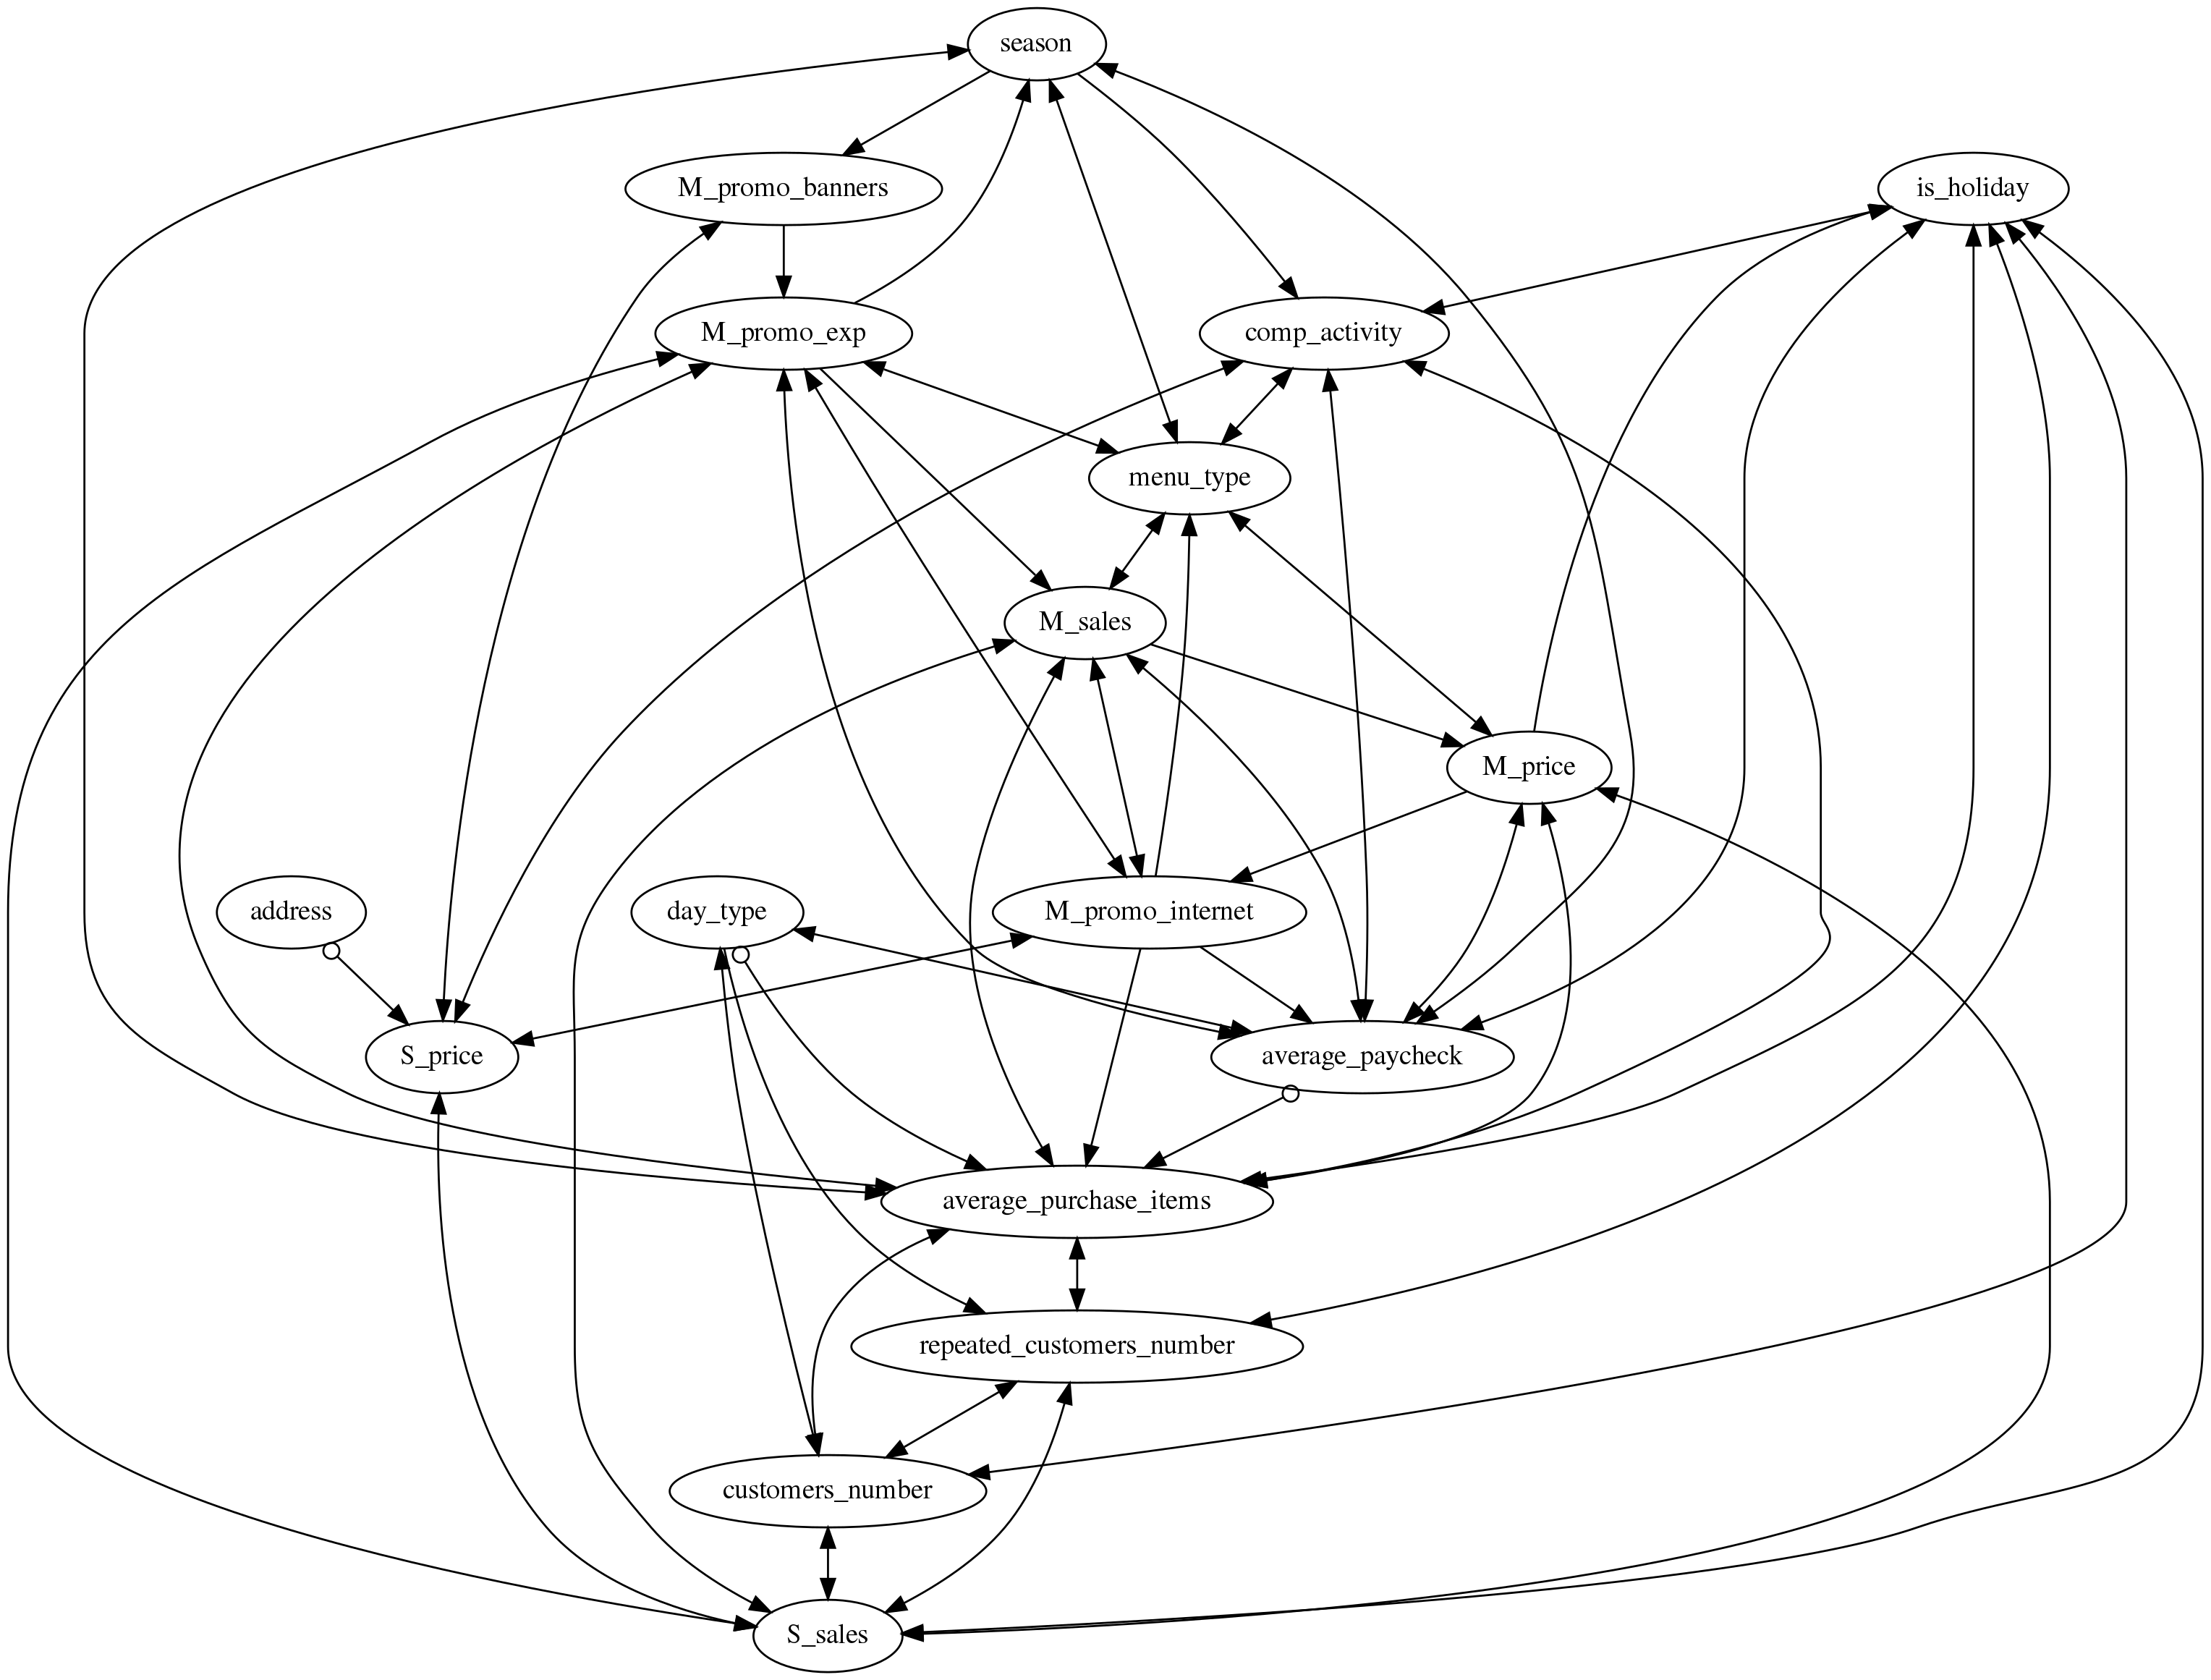

In [ ]:
Image('fci_graph.png')

In [48]:
fci_graph = nx.DiGraph(nx.nx_pydot.read_dot('graph_fci_custom.dot'))

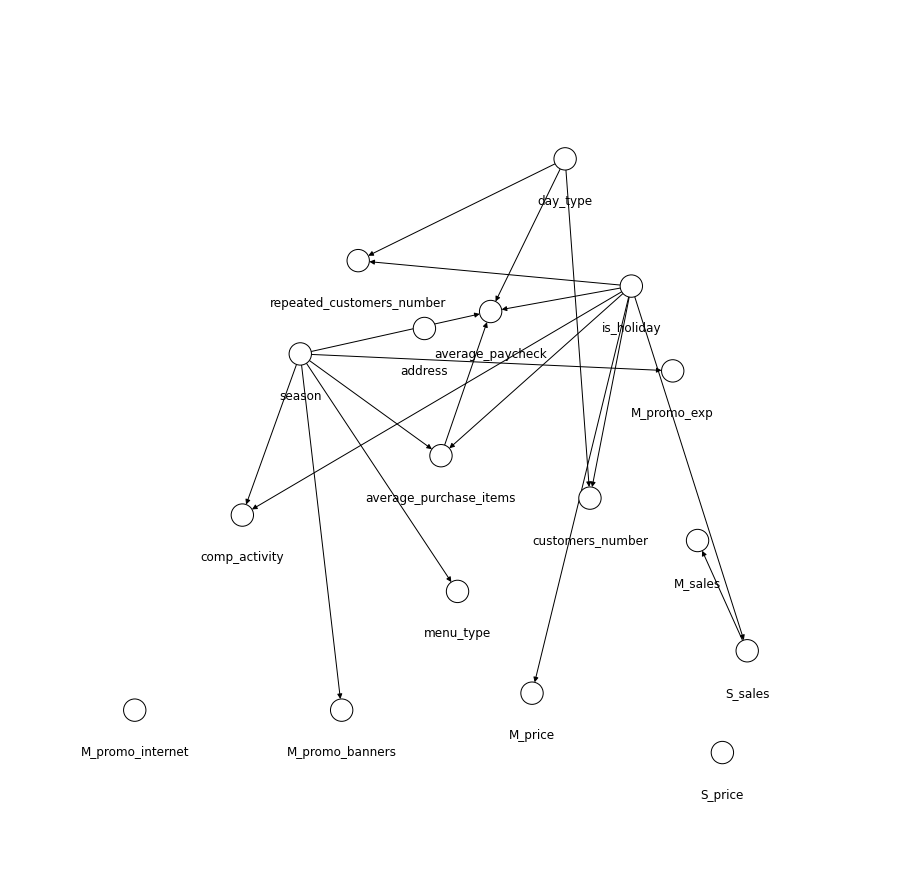

In [51]:
draw_graph(fci_graph, pos)

In [50]:
edges_to_remove = [(u, v) for u, v in fci_graph.edges() if v == 'is_holiday']
edges_to_remove += [(u, v) for u, v in fci_graph.edges() if v == 'day_type']
edges_to_remove += [(u, v) for u, v in fci_graph.edges() if v == 'season']
edges_to_remove += [(u, v) for u, v in fci_graph.edges() if v == 'address']
fci_graph.remove_edges_from([('M_sales', 'S_sales')])
edges_to_remove = [(u, v) for u, v in fci_graph.edges if (u, v) in get_non_directed_edges(fci_graph)]

fci_graph.remove_edges_from(edges_to_remove)

In [ ]:
model = CausalModel(
        data=df,
        treatment='S_sales',
        outcome='M_sales',
        graph=fci_graph)

identified_estimand = model.identify_effect()
print(identified_estimand)

estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")
print("Оценка эффекта: " + str(estimate.value))

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d               
─────────(E[Mₛₐₗₑₛ])
d[Sₛₐₗₑₛ]           
Estimand assumption 1, Unconfoundedness: If U→{S_sales} and U→M_sales then P(M_sales|S_sales,,U) = P(M_sales|S_sales,)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                               -1⎤
 ⎢      d               ⎛      d                ⎞  ⎥
E⎢─────────────(Mₛₐₗₑₛ)⋅⎜─────────────([Sₛₐₗₑₛ])⎟  ⎥
 ⎣d[is_holiday]         ⎝d[is_holiday]          ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→M_sales then ¬(U →→{is_holiday})
Estimand assumption 2, Exclusion: If we remove {is_holiday}→{S_sales}, then ¬({is_holiday}→M_sales)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

Оценка эффекта: -0.9311992463210004


In [52]:
fci_edges = pd.DataFrame(columns=['from', 'to'])

for edge in list(graph.edges()):
    fci_edges.loc[len(fci_edges)] = edge
    
fci_edges.to_csv('fci_edges.csv')

In [53]:
fci_edges.shape

# Алгоритм GRaSP

In [ ]:
from causallearn.search.PermutationBased.GRaSP import grasp

G = grasp(df.values)

In [ ]:
import io
from causallearn.utils.GraphUtils import GraphUtils

pyd = GraphUtils.to_pydot(G, labels=df.columns)
pyd.write_png('graph_grasp.png')

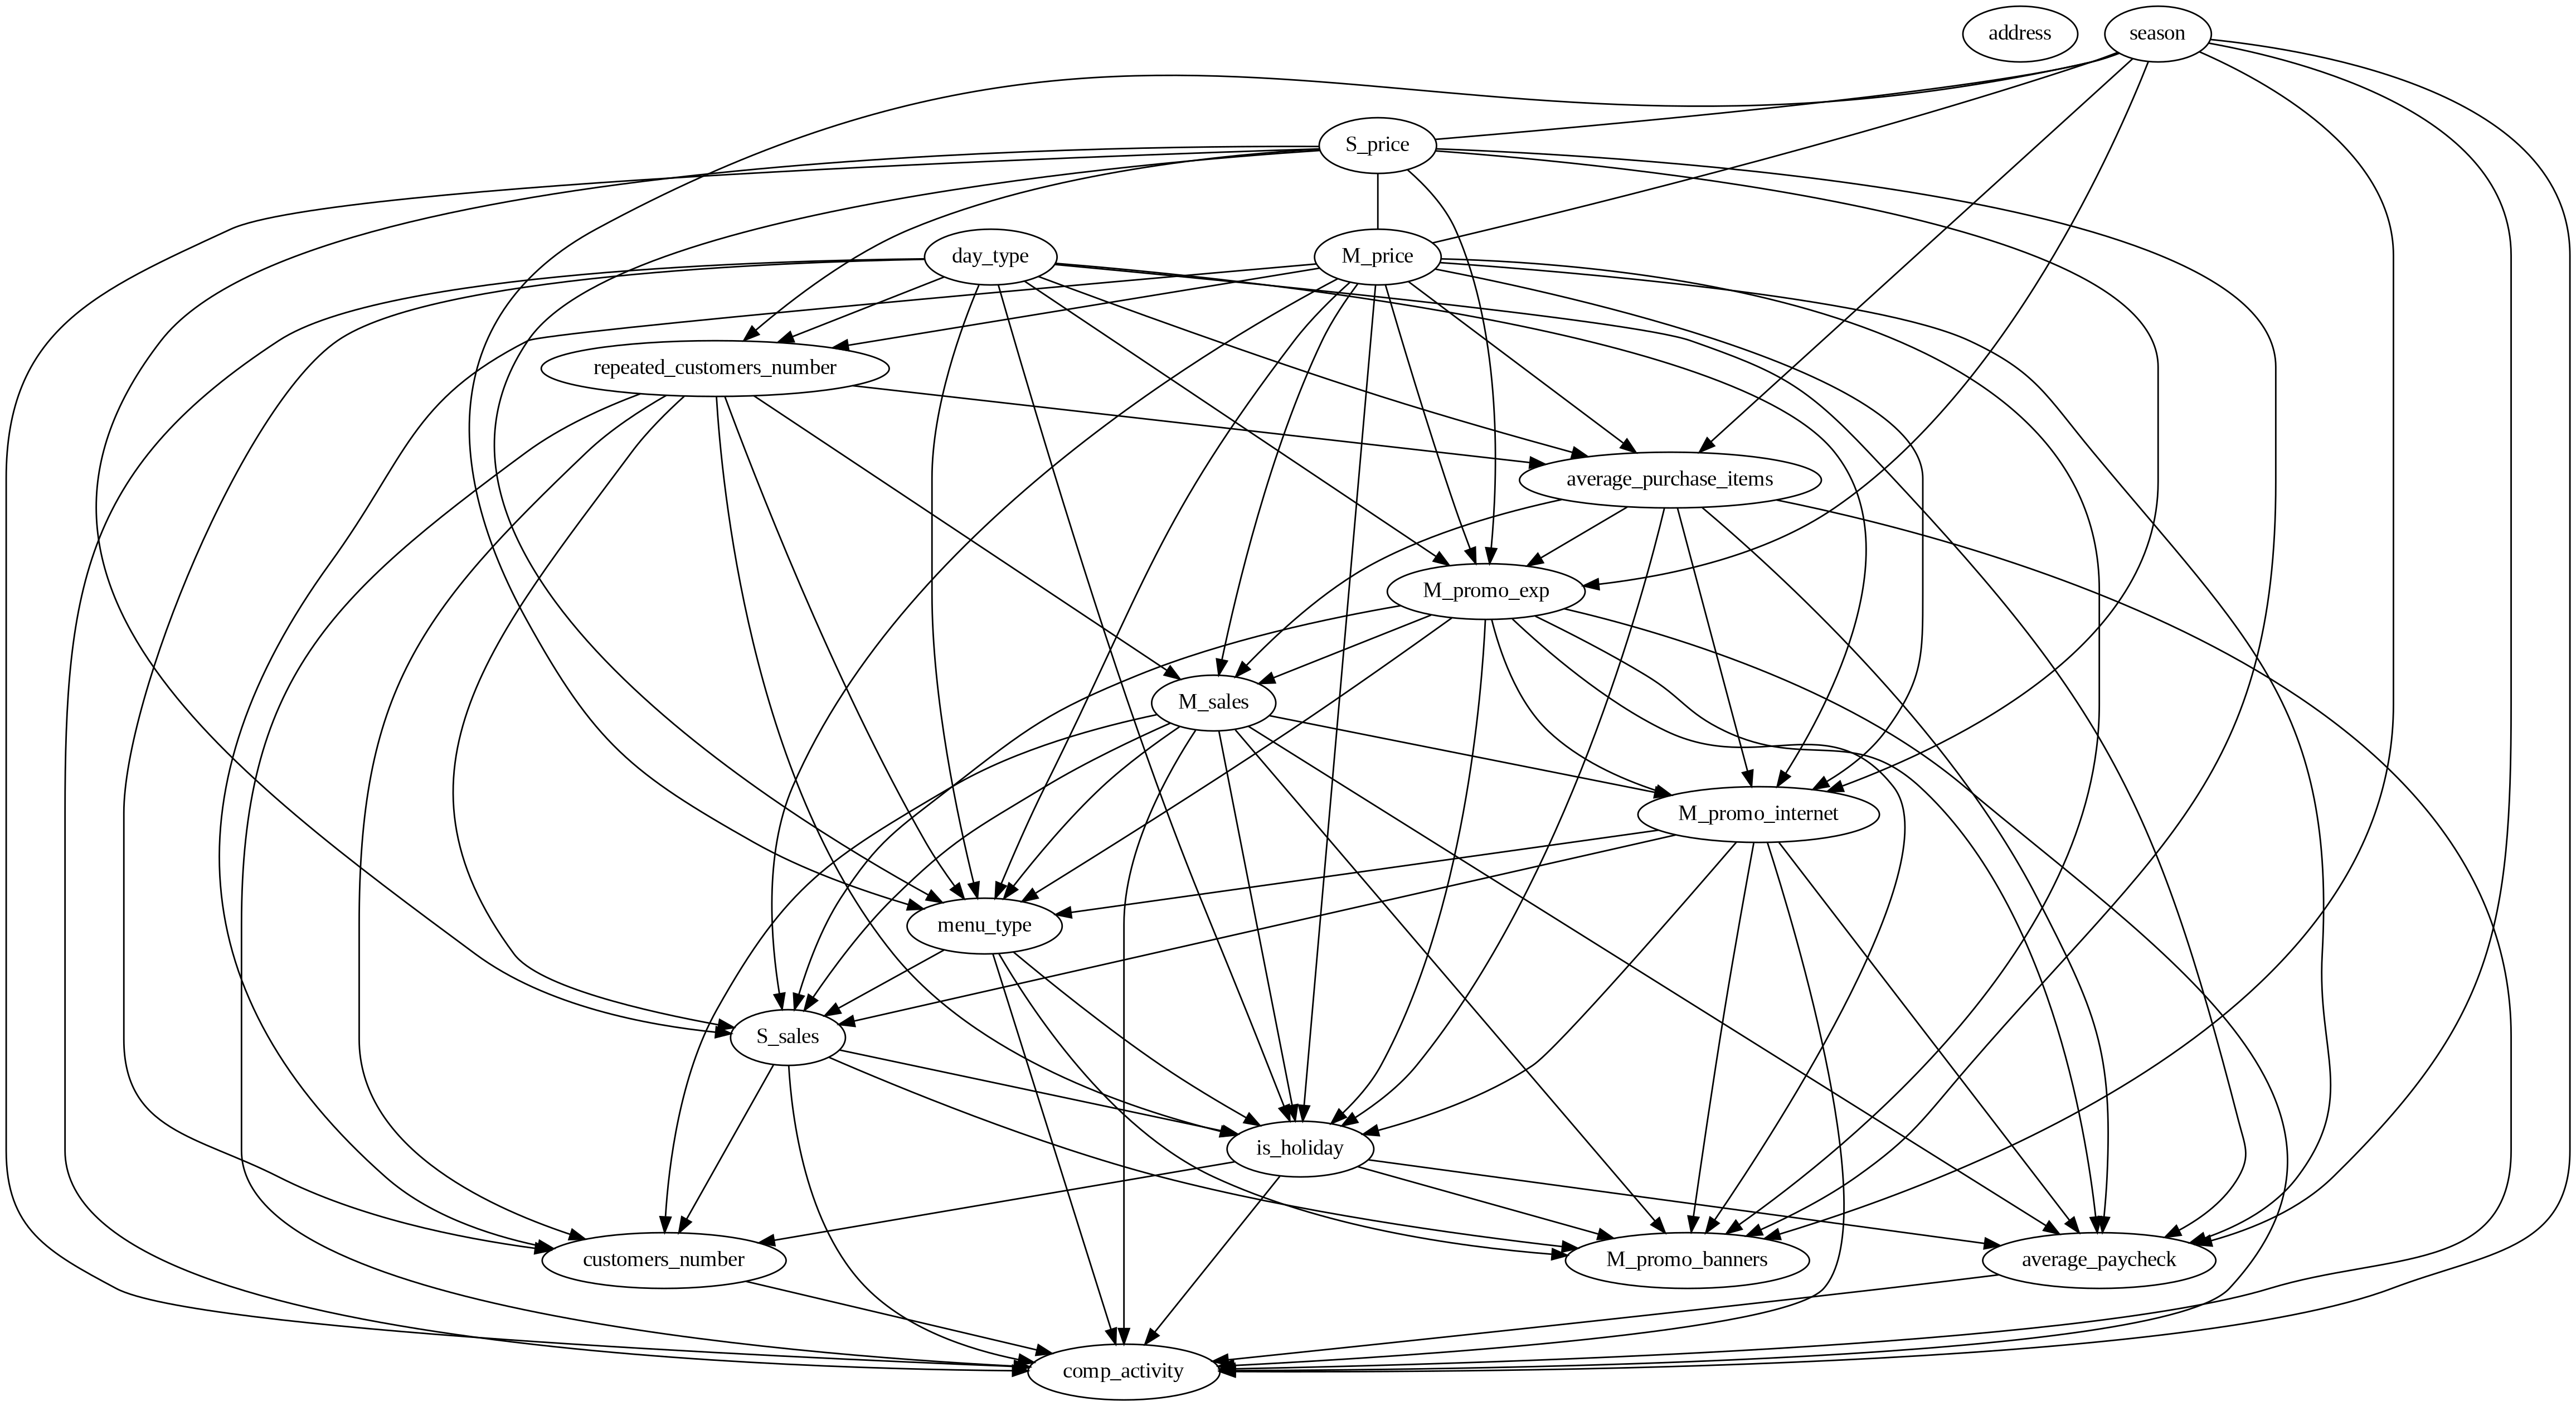

In [ ]:
from IPython.display import Image

Image('graph_grasp.png')

In [ ]:
nodes = G.get_nodes()
node_names = list(df.columns)

for i in range(len(nodes)):
    for j in range(len(nodes)):
        edge = G.get_edge(nodes[i], nodes[j])
        if edge is not None:
            print(node_names[i], '->', node_names[j])

is_holiday -> day_type
is_holiday -> comp_activity
is_holiday -> M_promo_exp
is_holiday -> M_promo_internet
is_holiday -> M_promo_banners
is_holiday -> M_price
is_holiday -> menu_type
is_holiday -> average_purchase_items
is_holiday -> average_paycheck
is_holiday -> repeated_customers_number
is_holiday -> customers_number
is_holiday -> M_sales
is_holiday -> S_sales
day_type -> is_holiday
day_type -> comp_activity
day_type -> M_promo_exp
day_type -> M_promo_internet
day_type -> menu_type
day_type -> average_purchase_items
day_type -> average_paycheck
day_type -> repeated_customers_number
day_type -> customers_number
season -> comp_activity
season -> M_promo_exp
season -> M_promo_banners
season -> S_price
season -> M_price
season -> menu_type
season -> average_purchase_items
season -> average_paycheck
comp_activity -> is_holiday
comp_activity -> day_type
comp_activity -> season
comp_activity -> M_promo_exp
comp_activity -> M_promo_internet
comp_activity -> S_price
comp_activity -> menu_ty

In [ ]:
for node in node_names:
    print(node, end='; ')

address; is_holiday; day_type; season; comp_activity; M_promo_exp; M_promo_internet; M_promo_banners; S_price; M_price; menu_type; average_purchase_items; average_paycheck; repeated_customers_number; customers_number; M_sales; S_sales; 

In [73]:
graph = nx.DiGraph(nx.nx_pydot.read_dot('graph_grasp.dot'))

In [75]:
edges_to_remove = [(u, v) for u, v in graph.edges() if v == 'is_holiday']
edges_to_remove += [(u, v) for u, v in graph.edges() if v == 'day_type']
edges_to_remove += [(u, v) for u, v in graph.edges() if v == 'season']
edges_to_remove += [(u, v) for u, v in graph.edges() if v == 'address']

graph.remove_edges_from(edges_to_remove)

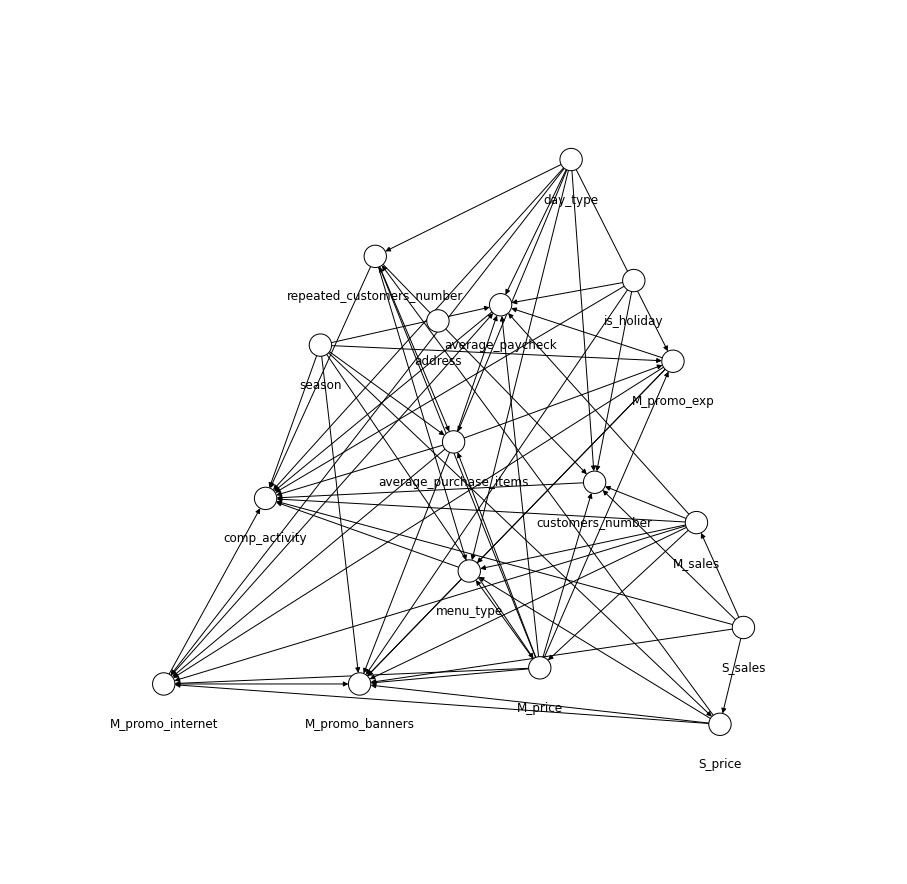

In [77]:
draw_graph(graph, pos)

In [76]:
edges_to_remove = [(u, v) for u, v in graph.edges if (u, v) in get_non_directed_edges(graph)]
graph.remove_edges_from(edges_to_remove)

In [74]:
graph.remove_edge('M_promo_internet', 'menu_type')
graph.remove_edge('M_promo_internet', 'S_sales')
graph.remove_edge('menu_type', 'S_sales')
graph.remove_edge('S_price', 'M_promo_exp')
graph.remove_edge('M_promo_exp', 'S_sales')
graph.remove_edge('average_purchase_items', 'M_sales')
graph.remove_edge('repeated_customers_number', 'M_sales')
graph.remove_edge('repeated_customers_number', 'S_sales')
graph.remove_edge('M_promo_exp', 'M_sales')

In [ ]:
nodes = list(graph.nodes)

for node1 in nodes:
    for node2 in nodes:
        if graph.has_edge(node1, node2):
            model = CausalModel(
              data=df,
              treatment=node1,
              outcome=node2,
              graph=graph)
            estimate = model.estimate_effect(identified_estimand,
                  method_name="backdoor.linear_regression")
            if abs(estimate.value) < 0.2:
                graph.remove_edge(node1, node2)
                print(node1, node2)

is_holiday customers_number
day_type comp_activity
day_type M_promo_exp
day_type M_promo_internet
day_type menu_type
day_type average_purchase_items
day_type average_paycheck
day_type repeated_customers_number
day_type customers_number
season comp_activity
season M_promo_banners
season average_paycheck
S_price M_promo_internet
S_price M_promo_banners
S_price menu_type
S_price repeated_customers_number
customers_number comp_activity


In [ ]:
model = CausalModel(
        data=df,
        treatment='S_sales',
        outcome='M_sales',
        graph=graph)

identified_estimand = model.identify_effect()
print(identified_estimand)

estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")
print("Оценка эффекта: " + str(estimate.value))

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d               
─────────(E[Mₛₐₗₑₛ])
d[Sₛₐₗₑₛ]           
Estimand assumption 1, Unconfoundedness: If U→{S_sales} and U→M_sales then P(M_sales|S_sales,,U) = P(M_sales|S_sales,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

Оценка эффекта: -0.9311992463210004


In [78]:
grasp_edges = pd.DataFrame(columns=['from', 'to'])

for edge in list(graph.edges()):
    grasp_edges.loc[len(grasp_edges)] = edge
    
grasp_edges.to_csv('grasp_edges.csv')

In [79]:
grasp_edges.shape

# Desbordante

Desbordante -- это инструмент для извлечения функциональных зависимостей из данных.

Извлекаем ФЗ при помощи Desbordante, а затем строим по ним граф и применяем background knowledge.

In [1]:
!pip install desbordante

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 17.9 MB/s eta 0:00:00


In [20]:
df.to_csv('ci_data_internship_2.csv')

In [39]:
import desbordante

TABLE = 'ci_data_internship_2.csv'

algo = desbordante.fd.algorithms.Default()
algo.load_data(table=(TABLE, ',', True))
algo.execute()
result = algo.get_fds()
print('FDs:')
for fd in result:
    print(fd)

FDs:
[] -> average_purchase_items
[] -> average_paycheck
[] -> S_sales
[] -> M_sales
[] -> address
[] -> customers_number
[] -> repeated_customers_number
[] -> S_price
[] -> menu_type
[] -> M_promo_exp
[] -> M_promo_internet
[] -> M_promo_banners
[] -> M_price
[] -> season
[] -> comp_activity
[] -> day_type
[] -> is_holiday
[address average_purchase_items average_paycheck M_sales S_sales] -> M_promo_exp
[address average_purchase_items average_paycheck M_sales S_sales] -> M_promo_internet
[address average_purchase_items average_paycheck M_sales S_sales] -> M_promo_banners
[address average_purchase_items average_paycheck M_sales S_sales] -> M_price
[address average_purchase_items average_paycheck M_sales S_sales] -> is_holiday
[address average_purchase_items average_paycheck customers_number M_sales S_sales] -> 
[address average_purchase_items average_paycheck customers_number M_sales S_sales] -> repeated_customers_number
[address average_purchase_items average_paycheck customers_number 

In [46]:
adjacency_matrix = [[0 for j in range(len(df.columns))] for i in range(len(df.columns))]
nodes = list(df.columns)
d = {nodes[i]: i for i in range(len(df.columns))}

for fd in result:
    lhs, rhs = str(fd).split(' -> ')
    lhs = lhs[1:-1].split()
    if rhs != ' ' and rhs != '' and len(lhs) != 0:
        for node in lhs:
            if node == '':
                continue
            adjacency_matrix[d[node]][d[rhs]] = 1

graph = nx.from_numpy_array(np.array(adjacency_matrix), create_using=nx.DiGraph)

In [47]:
graph = nx.relabel_nodes(graph, {i: nodes[i] for i in range(len(df.columns))})

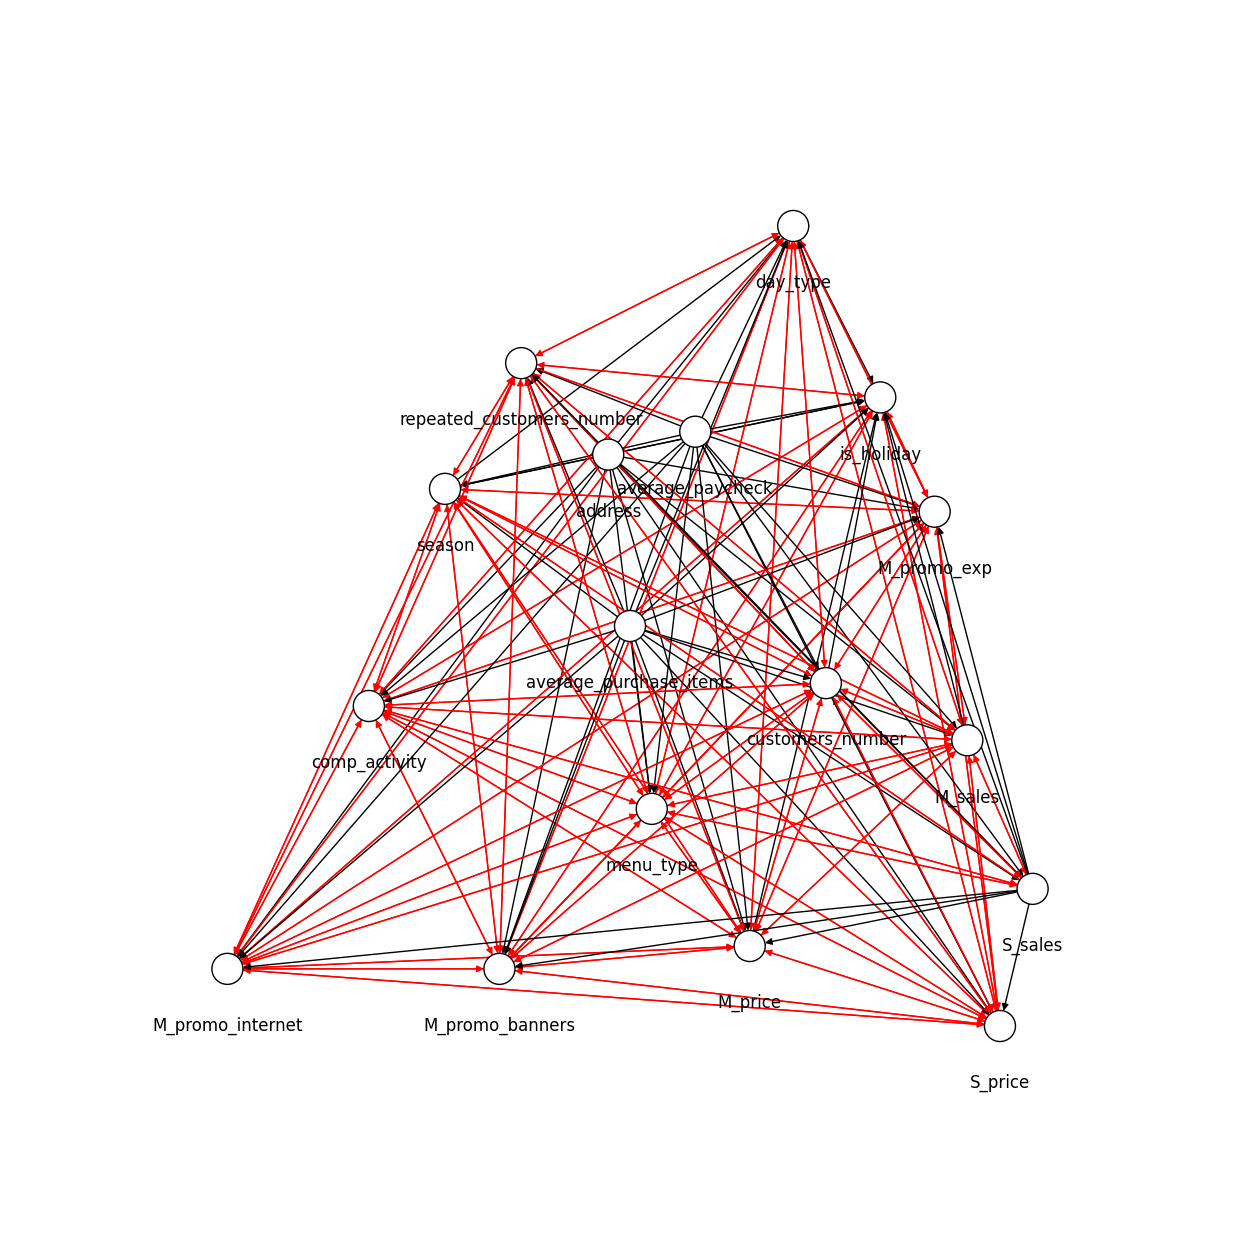

In [42]:
draw_graph(graph, pos)

In [48]:
edges_to_remove = [(u, v) for u, v in graph.edges() if v == 'is_holiday']
edges_to_remove += [(u, v) for u, v in graph.edges() if v == 'day_type']
edges_to_remove += [(u, v) for u, v in graph.edges() if v == 'season']
edges_to_remove += [(u, v) for u, v in graph.edges() if v == 'address']
graph.remove_edges_from([('M_sales', 'S_sales')])
edges_to_remove = [(u, v) for u, v in graph.edges if (u, v) in get_non_directed_edges(graph)]

graph.remove_edges_from(edges_to_remove)

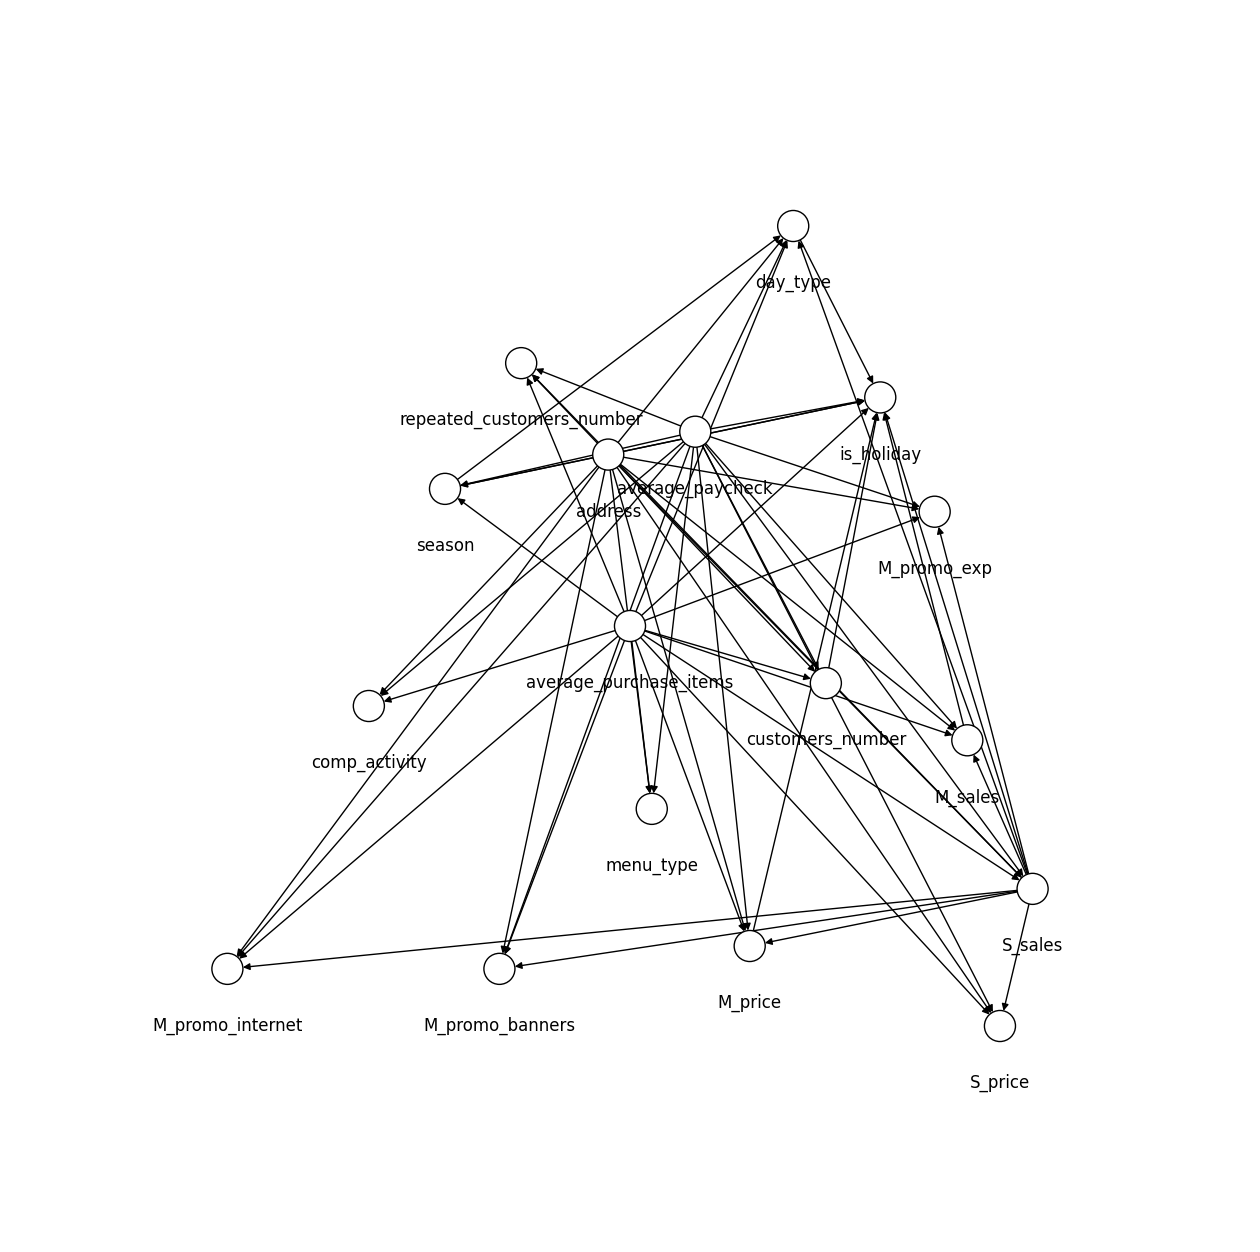

In [49]:
draw_graph(graph, pos)

In [50]:
model = CausalModel(
        data=df,
        treatment='S_sales',
        outcome='M_sales',
        graph=graph)

identified_estimand = model.identify_effect()
print(identified_estimand)

estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")
print("Оценка эффекта: " + str(estimate.value))

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                                                                
─────────(E[M_sales|average_paycheck,average_purchase_items,address])
d[Sₛₐₗₑₛ]                                                            
Estimand assumption 1, Unconfoundedness: If U→{S_sales} and U→M_sales then P(M_sales|S_sales,average_paycheck,average_purchase_items,address,U) = P(M_sales|S_sales,average_paycheck,average_purchase_items,address)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

Оценка эффекта: -0.6085022649245388


In [80]:
pc_edges = pd.read_csv('pc_edges.csv')
ges_edges = pd.read_csv('ges_edges.csv')
fci_edges = pd.read_csv('fci_edges.csv')
grasp_edges = pd.read_csv('grasp_edges.csv')
desbordante_edges = pd.read_csv('desbordante_edges.csv')

In [84]:
pc_edges_set = set(map(lambda p: (p[1], p[2]), pc_edges.values.tolist()))
ges_edges_set = set(map(lambda p: (p[1], p[2]), ges_edges.values.tolist()))
fci_edges_set = set(map(lambda p: (p[1], p[2]), fci_edges.values.tolist()))
grasp_edges_set = set(map(lambda p: (p[1], p[2]), grasp_edges.values.tolist()))
desbordante_edges_set = set(map(lambda p: (p[1], p[2]), desbordante_edges.values.tolist()))

In [87]:
print(len(pc_edges_set & ges_edges_set))
print(len(pc_edges_set & fci_edges_set))
print(len(pc_edges_set & grasp_edges_set))
print(len(pc_edges_set & desbordante_edges_set))
print(len(ges_edges_set & fci_edges_set))
print(len(ges_edges_set & grasp_edges_set))
print(len(ges_edges_set & desbordante_edges_set))
print(len(fci_edges_set & grasp_edges_set))
print(len(fci_edges_set & desbordante_edges_set))
print(len(grasp_edges_set & desbordante_edges_set))

9
9
16
4
37
19
28
19
28
17


In [89]:
len(pc_edges_set)

In [95]:
ges_edges_set

{('M_promo_exp', 'S_price'),
 ('M_sales', 'M_price'),
 ('M_sales', 'average_purchase_items'),
 ('M_sales', 'repeated_customers_number'),
 ('S_sales', 'M_promo_exp'),
 ('S_sales', 'M_sales'),
 ('S_sales', 'S_price'),
 ('S_sales', 'menu_type'),
 ('S_sales', 'repeated_customers_number'),
 ('day_type', 'M_promo_internet'),
 ('day_type', 'average_paycheck'),
 ('day_type', 'average_purchase_items'),
 ('day_type', 'customers_number'),
 ('day_type', 'repeated_customers_number'),
 ('is_holiday', 'M_price'),
 ('is_holiday', 'M_promo_banners'),
 ('is_holiday', 'M_promo_internet'),
 ('is_holiday', 'S_price'),
 ('is_holiday', 'S_sales'),
 ('is_holiday', 'average_paycheck'),
 ('is_holiday', 'average_purchase_items'),
 ('is_holiday', 'comp_activity'),
 ('is_holiday', 'customers_number'),
 ('is_holiday', 'menu_type'),
 ('is_holiday', 'repeated_customers_number'),
 ('menu_type', 'M_promo_internet'),
 ('season', 'M_price'),
 ('season', 'M_promo_banners'),
 ('season', 'M_promo_exp'),
 ('season', 'M_promo